# Lead Detection CNN Using Co-located Sentinel-3 SAR and OLCI data 

## Functions
The functions required to find pulse peakiness (PP), Stack Standard deviation (SSD) and to unpack Sentinel-3 SAR data variables are defined below:

In [1]:
#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================


def peakiness(waves, **kwargs):  
    
    "finds peakiness of waveforms." 

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \
     
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")
    size=np.shape(waves)[0]
    
    waves1=np.copy(waves)
    
    if waves1.ndim == 1:
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1))
        waves1=waves2

    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky')

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):
        
    from scipy.interpolate import interp1d
        
    time_1hz=SAR_data.variables['time_counter_1Hz'][:]
    time_20hz=SAR_data.variables['time_counter_20Hz'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan) 
        
    if len(out)==len(time_1hz):
            
        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)  

    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'
    
    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])
    
    for i in range(np.shape(RIP)[0]):
    
        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)                          
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])
            
    
    return SSD


## OLCI, SAR and SL SAR Classification Data Files

In [2]:
print('OLCI data directories:')
#! ls /Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/OLCI
! ls ../OLCI_test
print('')
print('SAR tracks:')
# ! ls /Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/GPOD_PROCESSED/201803
! ls ../GPOD_PROCESSED_test/201803/
print('')
print('SAR track classification files (lead_floe_flag files):')
# ! ls /Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/GPOD_PROCESSED/201803/lead_floe_flags
! ls ../GPOD_PROCESSED_test/201803/lead_floe_flags/

OLCI data directories:
S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3

SAR tracks:
RES_S3A_SR_1_SRA_A__20180304T001114_20180304T010144_20180329T213842_3029_028_273_GPOD_SAR_O_NT_003.nc
lead_floe_flags

SAR track classification files (lead_floe_flag files):
RES_S3A_SR_1_SRA_A__20180304T001114_20180304T010144_20180329T213842_3029_028_273_GPOD_SAR_O_NT_00_lead.nc


## The OLCI Data 

Below we look at the data from the first OLCI file
- Along the SAR track is taken as the y direction 
- Across the SAR track is taken as the x direction 

In [3]:
# ! ls ..

In [3]:
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

# dir_path='/Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/'
dir_path='../'
with open(dir_path+'select_files_test.txt') as f:
    selects = [line.rstrip('\n') for line in open(dir_path+'select_files_test.txt')]
 
with open(dir_path+'matching_SAR_tracks_test.txt') as f:
    matching_SAR_list = [line.rstrip('\n') for line in open(dir_path+'matching_SAR_tracks_test.txt')]
    
j=-1

for file in selects[0:1]:
    startindex=(file.index('S3A_OL_1_EFR_'))

    j=j+1
#     startindex=(file.index('S3A_OL_1_EFR_'))
#    OLCI_file='/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/'+file[startindex:-9]
#    OLCI_file='/Volumes/OLCI/'+file[startindex:-9]
    OLCI_file=dir_path+'OLCI_test/'+file[startindex:-9]
    print('OLCI file', file[startindex:-9])
    tif_file=OLCI_file+'/true_color.tif'    
    
    geo_coords=Dataset(OLCI_file+'/geo_coordinates.nc')
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]
    OLCI_lon_r=OLCI_lon.ravel()
    OLCI_lat_r=OLCI_lat.ravel()
    
    print('Shape of OLCI lon/lat data:',(OLCI_lon).shape)
    print('Number of OLCI pixels:', len(OLCI_lon_r))
    print('Variable keys for OLCI nc data:')

    # looping over all radaince bands for OLCI_data array    
    OLCI_data=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file+'/Oa'+Rstr+'_radiance.nc')
        print(OLCI_nc.variables.keys())
        OLCI_data.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']))    
              
    #  looping over all radaince bands for OLCI_data array with ravlled elements  
    OLCI_data_r=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file+'/Oa'+Rstr+'_radiance.nc')
        OLCI_data_r.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']).ravel())

    
#     print(OLCI_nc['Oa21_radiance'][:]) 
#     print((OLCI_nc['Oa21_radiance'][:]).shape)  
#     print(np.nanmean(OLCI_nc['Oa21_radiance'][:]))
    print('Number of OLCI radiance bands:', Radiance)
    print('Shape of OLCI data:', np.shape(OLCI_data)) # numpy described 2D arrays (rows, columns) --> (y,x)
    print('Shape of one radiance band of OLCI data:',np.shape(OLCI_data[0]))
    print('Length of a column (number of rows) --> y --> along SAR track direction:',len(OLCI_data[0]))
    print('Length of a row (number of columns) --> x --> across SAR track direction:', len(OLCI_data[0][0])) 
    print('Radiance band 1 OLCI data:')
    print(OLCI_data[0])
#     print(OLCI_data[0][0])
    print('')
    print('Shape of ravelled OLCI data:', np.shape(OLCI_data_r))
    print('Shape of one radiance band of ravelled OLCI data:',np.shape(OLCI_data_r[0]))
    print('Radiance band 1 ravelled OLCI data:')
    print(OLCI_data_r[0])


OLCI file S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3
Shape of OLCI lon/lat data: (1145, 4865)
Number of OLCI pixels: 5570425
Variable keys for OLCI nc data:
odict_keys(['Oa01_radiance'])
odict_keys(['Oa02_radiance'])
odict_keys(['Oa03_radiance'])
odict_keys(['Oa04_radiance'])
odict_keys(['Oa05_radiance'])
odict_keys(['Oa06_radiance'])
odict_keys(['Oa07_radiance'])
odict_keys(['Oa08_radiance'])
odict_keys(['Oa09_radiance'])
odict_keys(['Oa10_radiance'])
odict_keys(['Oa11_radiance'])
odict_keys(['Oa12_radiance'])
odict_keys(['Oa13_radiance'])
odict_keys(['Oa14_radiance'])
odict_keys(['Oa15_radiance'])
odict_keys(['Oa16_radiance'])
odict_keys(['Oa17_radiance'])
odict_keys(['Oa18_radiance'])
odict_keys(['Oa19_radiance'])
odict_keys(['Oa20_radiance'])
odict_keys(['Oa21_radiance'])
Number of OLCI radiance bands: 21
Shape of OLCI data: (21, 1145, 4865)
Shape of one radiance band of OLCI data: (1145, 4865)
Length of a column (number of r

## Dictionary for Co-located Sentinel-3 SAR and OLCI data 

In [7]:
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

# dir_path='/Users/dorsa/Downloads/ProcessIRL_S3_SAR_over_OLCI/'
dir_path='../'

with open(dir_path+'select_files_test.txt') as f:
    selects = [line.rstrip('\n') for line in open(dir_path+'select_files_test.txt')]
 
with open(dir_path+'matching_SAR_tracks_test.txt') as f:
    matching_SAR_list = [line.rstrip('\n') for line in open(dir_path+'matching_SAR_tracks_test.txt')]

j=-1

CNN_training={}

# nested 
# https://stackoverflow.com/questions/10756427/loop-through-all-nested-dictionary-values
# dic = {}
# dic["key1"] = {}
# dic["key1"]["key1.1"] = "value1"
# selects=glob.glob('/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/selects/*.png')

OLCI_file_list_orig=[]
OLCI_file_list=[]
for OLCI_file_orig in selects[0:1]:
    OLCI_file_list_orig.append(OLCI_file_orig)
    startindex=(OLCI_file_orig.index('S3A_OL_1_EFR_')) # start of the filenmaes in selects list indexed as 1  
    OLCI_file_list.append(OLCI_file_orig[startindex:-9]) # [startindex:-9] takes the .lres.png off the end of the filenames  
   
SAR_file_list=[]
SL_flagfile_list=[]
for OLCI_file in OLCI_file_list: 
    CNN_training[OLCI_file]={} 
       
    j=j+1
#    startindex=(file.index('S3A_OL_1_EFR_'))
#    OLCI_file='/Volumes/cpnet/li1_cpdata/SATS/OPTICAL/OLCI/'+file[startindex:-9]
#    OLCI_file='/Volumes/OLCI/'+file[startindex:-9]
    OLCI_file_p=dir_path+'OLCI_test/'+OLCI_file  # pathhway to OLCI_file
    print('OLCI file is:', selects[j])
    tif_file=OLCI_file_p+'/true_color.tif'

    geo_coords=Dataset(OLCI_file_p+'/geo_coordinates.nc')
    OLCI_lat=geo_coords['latitude'][:]
    OLCI_lon=geo_coords['longitude'][:]
    OLCI_lon_r=OLCI_lon.ravel()
    OLCI_lat_r=OLCI_lat.ravel()
 
    # loop over radiance bands for OLCI_data array:        
    OLCI_data=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file_p+'/Oa'+Rstr+'_radiance.nc')
        OLCI_data.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']))

    # loop over radiance bands for ravelled OLCI_data array:    
    OLCI_data_r=[]
    for Radiance in range(1,22):
        Rstr="%02d" % Radiance
        OLCI_nc=Dataset(OLCI_file_p+'/Oa'+Rstr+'_radiance.nc')
        OLCI_data_r.append(np.asarray(OLCI_nc['Oa'+Rstr+'_radiance']).ravel())
        CNN_training[OLCI_file]['Oa'+Rstr+'_radiance']=np.asarray(OLCI_nc['Oa'+Rstr+'_radiance'])
    
    CNN_training[OLCI_file]['OLCI_data']=OLCI_data
    CNN_training[OLCI_file]['OLCI_data_r']=OLCI_data_r
    
    print(np.shape(OLCI_data))
    print(np.shape(OLCI_data_r))
       
    # need to find corresponsing SAR file (timecodes are different):
    SAR_file=matching_SAR_list[j]
    SAR_file_list.append(SAR_file)
    print('Overlapping SAR file is:',SAR_file)
    SAR_data=Dataset(dir_path+'GPOD_PROCESSED_test/201803/'+SAR_file)
#    SAR_data=Dataset('/Volumes/cpdata/SATS/RA/S3A/L1B/GPOD_PROCESSED/201803/'+SAR_file)
#    SAR_data=Dataset(dir_path+'/Volumes/GPOD_PROCESSED/201803/'+SAR_file)

    SAR_lat, SAR_lon, waves, sig_0, RIP= unpack_gpod('latitude_20Hz'), unpack_gpod('longitude_20Hz'), unpack_gpod('SAR_Echo_Data'), unpack_gpod('Sigma0_20Hz'), unpack_gpod('Substack_RIP_Data')
    SAR_index=np.arange(np.size(SAR_lat))
    
# still need to do this?  
#     find=np.where(SAR_lat >= -180)
#     SAR_lat=SAR_lat[find]
#     SAR_lon=SAR_lon[find]
#     SAR_index=SAR_index[find]
#     waves=waves[find]
#     sig_0=sig_0[find]
#     RIP=RIP[find]
 
    PP=peakiness(waves)
    SSD=calculate_SSD(RIP)
    
    CNN_training[OLCI_file]["waves"]=waves
    CNN_training[OLCI_file]["sig_0"]=sig_0
    CNN_training[OLCI_file]["RIP"]=RIP
    CNN_training[OLCI_file]["PP"]=PP
    CNN_training[OLCI_file]["SSD"]=SSD
    CNN_training[OLCI_file]["SAR_index"]=SAR_index
    
    SL_flagfile_p=(dir_path+'GPOD_PROCESSED_test/201803/lead_floe_flags/'+SAR_file[0:-7]+'_00_lead.nc')
#     SL_flagfile_p=('/Volumes/GPOD_PROCESSED/201803/lead_floe_flags/'+SAR_file[0:-7]+'_00_lead.nc')
    SL_flagfile=SAR_file[0:-7]+'_00_lead.nc'
    flag_data=Dataset(SL_flagfile_p)
    flag=flag_data['lead_abun_1'][:]
    SL_flagfile_list.append(SL_flagfile)
#     flag_index= np.arange(np.size(flag))   
#     flag=flag[find]

    CNN_training[OLCI_file]["flag_data"]=flag_data
    CNN_training[OLCI_file]["flag"]=flag
#     CNN_training[OLCI_file]["flag_index"]=flag_index

    # convert lons to 360 degree format
    SAR_lon[SAR_lon<0]=360+SAR_lon[SAR_lon<0]
    OLCI_lon[OLCI_lon<0]=360+OLCI_lon[OLCI_lon<0]
    OLCI_lon_r[OLCI_lon_r<0]=360+OLCI_lon_r[OLCI_lon_r<0]
    
    # find centre of OLCI image
    central_lat=np.min(OLCI_lat_r)+0.5*(np.max(OLCI_lat_r)-np.min(OLCI_lat_r))
    central_lon=np.min(OLCI_lon_r)+0.5*(np.max(OLCI_lon_r)-np.min(OLCI_lon_r))
    print('OLCI central lat:', central_lat)
    print('OLCI central lon:', central_lon)
   
    # do Lambert Azimuthal Equal Area Projection (on a equal-area projection, the area is preserved but the shape is not)
    w=1200000
    m = Basemap(resolution='l',projection='laea',ellps='WGS84', lat_ts=0,  lat_0= central_lat, lon_0=central_lon, width=w,height=w)
    SAR_x,SAR_y=m(SAR_lon,SAR_lat)    
    OLCI_x,OLCI_y=m(OLCI_lon,OLCI_lat)
    OLCI_x_r,OLCI_y_r=m(OLCI_lon_r,OLCI_lat_r)

    spec = np.where(PP > 18.0)  # Same as CryoSat-2 
    spec = np.asarray(spec)
    spec = spec.flatten()

    diff = np.where(PP < 9.0)  # Same as CryoSat-2 
    diff = np.asarray(diff)
    diff = diff.flatten()

    spec_SL = np.where(flag==1)[0] # from Sanggyun lead (SL) detection algorithm
    spec_SL = np.asarray(spec_SL)
    spec_SL = spec_SL.flatten()

    diff_SL = np.where(flag==0)[0]
    diff_SL = np.asarray(diff_SL)
    diff_SL = diff_SL.flatten()
    
    
    CNN_training[OLCI_file]["SAR_lon"]=SAR_lon
    CNN_training[OLCI_file]["SAR_lat"]=SAR_lat
    CNN_training[OLCI_file]["SAR_x"]=SAR_x
    CNN_training[OLCI_file]["SAR_y"]=SAR_y
    
    CNN_training[OLCI_file]["OLCI_lon"]=OLCI_lon
    CNN_training[OLCI_file]["OLCI_lat"]=OLCI_lat
    CNN_training[OLCI_file]["OLCI_x"]=OLCI_x
    CNN_training[OLCI_file]["OLCI_y"]=OLCI_y
    CNN_training[OLCI_file]["OLCI_lon_r"]=OLCI_lon_r
    CNN_training[OLCI_file]["OLCI_lat_r"]=OLCI_lat_r
    CNN_training[OLCI_file]["OLCI_x_r"]=OLCI_x_r
    CNN_training[OLCI_file]["OLCI_y_r"]=OLCI_y_r
    
    CNN_training[OLCI_file]["spec"]=spec
    CNN_training[OLCI_file]["diff"]=diff
    CNN_training[OLCI_file]["spec_SL"]=spec_SL
    CNN_training[OLCI_file]["diff_SL"]=diff_SL
    
    
    # do a KDtree to find all OLCI points within a 4km diameter (2km radius) of each SAR footprint.
    points=(OLCI_x_r,OLCI_y_r)
    points=np.transpose(points)
    point_tree = spatial.cKDTree(points)

    nearby_x=[]
    nearby_y=[]
    nearby_z=[]
    match_indices_list=[]
    distances=[]

    for i in range(np.size(SAR_x)): 
        SAR_array=[]
        coordinate=[SAR_x[i],SAR_y[i]]
        
        match_indices=point_tree.query_ball_point(coordinate, 2000) # search radius in metres

        # check distance from each of the OLCI points
        distance_array=[]
        for match_index in match_indices: 
            dist=np.sqrt((OLCI_x_r[match_index]-SAR_x[i])**2+(OLCI_y_r[match_index]-SAR_y[i])**2)
            distance_array.append(dist)
        
        # re-order the nearest OCLI pixels from lowest to highest distance from the SAR point
        paired=tuple(zip(distance_array,match_indices))
        sort_distance=sorted(paired,key=lambda x: x[0]) # key tells function how to sort it (x[0] is distance element)--> lambda functions are basically anonymous functions- iterate over the list
        match_indices_o=[x[1] for x in sort_distance] # distance ordered match indices list
        
        # create an array of distances
        distance_array_2=[]
        for match_index_o in match_indices_o: 
            dist_2=np.sqrt((OLCI_x_r[match_index_o]-SAR_x[i])**2+(OLCI_y_r[match_index_o]-SAR_y[i])**2)
            distance_array_2.append(dist_2)
        distances.append(distance_array_2)
        
        # everything in terms of distance ordered indices (match_indices_o)
        match_indices_list.append(match_indices_o)
        nearby_x.append(OLCI_x_r[match_indices_o])   
        nearby_y.append(OLCI_y_r[match_indices_o])
        
        for Radiance in range(1,22):
            indices_array=[]
            for match_index_o in match_indices_o:
                indices_array.append(OLCI_data_r[Radiance-1][match_index_o])
            SAR_array.append(indices_array)
        nearby_z.append(SAR_array)        

    CNN_training[OLCI_file]["match_indices_list"]=match_indices_list        
    CNN_training[OLCI_file]["nearby_x"]=nearby_x        
    CNN_training[OLCI_file]["nearby_y"]=nearby_y        
    CNN_training[OLCI_file]["nearby_z"]=nearby_z
    CNN_training[OLCI_file]["distances"]=distances  


OLCI file is: S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3.lres.png
(21, 1145, 4865)
(21, 5570425)
Overlapping SAR file is: RES_S3A_SR_1_SRA_A__20180304T001114_20180304T010144_20180329T213842_3029_028_273_GPOD_SAR_O_NT_003.nc
Running peakiness function...


/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in true_divide
/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: invalid value encountered in true_divide
/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of ca

/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:114: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type


OLCI central lat: 73.053856
OLCI central lon: 164.93655


/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [8]:
print('Master', CNN_training.keys())
print('')
print('Each image/track', CNN_training[OLCI_file].keys())
print('')
print('Original OLCI files:', OLCI_file_list_orig)
print('')
print('OLCI files:', OLCI_file_list)
print('')
print('SAR files:', SAR_file_list)
print('')
print('SL flag files:', SL_flagfile_list)


Master dict_keys(['S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3'])

Each image/track dict_keys(['Oa01_radiance', 'Oa02_radiance', 'Oa03_radiance', 'Oa04_radiance', 'Oa05_radiance', 'Oa06_radiance', 'Oa07_radiance', 'Oa08_radiance', 'Oa09_radiance', 'Oa10_radiance', 'Oa11_radiance', 'Oa12_radiance', 'Oa13_radiance', 'Oa14_radiance', 'Oa15_radiance', 'Oa16_radiance', 'Oa17_radiance', 'Oa18_radiance', 'Oa19_radiance', 'Oa20_radiance', 'Oa21_radiance', 'OLCI_data', 'OLCI_data_r', 'waves', 'sig_0', 'RIP', 'PP', 'SSD', 'SAR_index', 'flag_data', 'flag', 'SAR_lon', 'SAR_lat', 'SAR_x', 'SAR_y', 'OLCI_lon', 'OLCI_lat', 'OLCI_x', 'OLCI_y', 'OLCI_lon_r', 'OLCI_lat_r', 'OLCI_x_r', 'OLCI_y_r', 'spec', 'diff', 'spec_SL', 'diff_SL', 'match_indices_list', 'nearby_x', 'nearby_y', 'nearby_z', 'distances'])

Original OLCI files: ['S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3.lres.png']

OLCI files

## Checking Dictionary Values 

**Checking OLCI nearest neighbours are ordered in increasing distance order from SAR point**
- If nothing is printed, distances are in increasing order

In [9]:
k=-1
for OLCI_file in OLCI_file_list:
    k=k+1
    SAR_lon=CNN_training[OLCI_file]["SAR_lon"]
    distances=CNN_training[OLCI_file]["distances"]
    for j in range(np.size(SAR_lon)):
        for i in range(np.size(distances[j])):
            if i < (np.size(distances[j]))-1:
                if (distances[j][i+1]-distances[j][i])<0:
                    print(i)
            else:
                if (distances[j][i]-distances[j][i-1])<0:
                    print(i) # if nothing is printed it means it is correctly ordered 
    
#     # printing the distances of the OLCI neighbours from a specific SAR point 
#     if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
#         print('Checking that the nearest neighbours are in increaing distance order for the 5000th SAR point:')
#         print(distances[5000])
        
#     # further check- find the distances of the neighbouring OLCI points to the SAR point
#         N=5000
#         x0=SAR_x[N]
#         y0=SAR_y[N]

#         for i in range(len(match_indices_list[N])):
#             x=OLCI_x_r[match_indices_list[N]][i]
#             y=OLCI_y_r[match_indices_list[N]][i]
#             dx=x-x0
#             dy=y-y0
#             print(i,np.sqrt(dx**2.+dy**2))

**Checking dimensions and values**- looking at one image and track

In [10]:
k=-1
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[1]: # change this to look at other images/tracks
        k=k+1
        print('For OLCI and SAR file',k+1)
        print('OLCI file is:', OLCI_file)
        print('')
        print('Shape of OLCI data:', np.shape(CNN_training[OLCI_file]['OLCI_data']))
        print('Shape of ravelled OLCI data:', np.shape(CNN_training[OLCI_file]['OLCI_data_r']))
        print('')
        print('Number of SAR points:', np.shape(CNN_training[OLCI_file]['SAR_x']))
        print('')
        print('The length of match_indices_list, nearby_x, nearby_y, distances and flags are the same as the number of SAR points:')
        print(np.shape(CNN_training[OLCI_file]['match_indices_list']))
#         print(np.shape(CNN_training[OLCI_file]['nearby_x']))
#         print(np.shape(CNN_training[OLCI_file]['nearby_y']))
#         print(np.shape(CNN_training[OLCI_file]['distances']))
#         print(np.shape(CNN_training[OLCI_file]['flag']))
        print('')
        print('nearby_z is a nested list where each element (equal to the number of SAR points) has 21 lists:')
        print(np.shape(CNN_training[OLCI_file]['nearby_z']))
        print('')
        print('Number of OLCI points in the vicinity of 5000th SAR point:')
        print(len(CNN_training[OLCI_file]['match_indices_list'][5000]))
#         print(len(CNN_training[OLCI_file]['nearby_x'][5000]))
#         print(len(CNN_training[OLCI_file]['nearby_y'][5000]))
#         print(len(CNN_training[OLCI_file]['nearby_z'][5000][0]))
#         print(len(CNN_training[OLCI_file]['distances'][5000]))

#         # Looking at some values
#         print('')
#         print('match_indices_list for 5000th SAR point:')
#         print(CNN_training[OLCI_file]['match_indices_list'][5000])
#         print('')
#         print('nearby_x for 5000th SAR point:')
#         print(CNN_training[OLCI_file]['nearby_x'][5000])
#         print('')
#         print('nearby_y for 5000th SAR point:')
#         print(CNN_training[OLCI_file]['nearby_y'][5000])
#         print('')
#         print('nearby_z for first radiance band for 5000th SAR point:')
#         print(CNN_training[OLCI_file]['nearby_z'][5000][0])
#         print('')
#         print('flag for 5000th SAR point:')
#         print(CNN_training[OLCI_file]['flag'][5000])

IndexError: list index out of range

**Checking dimensions and values**- all images and tracks

In [11]:
k=-1
for OLCI_file in OLCI_file_list: 
    k=k+1
    print('For OLCI and SAR file',k+1)
    print('OLCI file is:', OLCI_file)
    print('Shape of OLCI data:', np.shape(CNN_training[OLCI_file]['OLCI_data']))
    print('Shape of ravelled OLCI data:', np.shape(CNN_training[OLCI_file]['OLCI_data_r']))
    print('Number of SAR points:', np.shape(CNN_training[OLCI_file]['SAR_x']))
    print('The length of match_indices_list, nearby_x, nearby_y, distances and flags are the same as the number of SAR points:')
    print('nearby_z is a nested list where each element (equal to the number of SAR points) has 21 lists:')
    print(np.shape(CNN_training[OLCI_file]['nearby_z']))
    print('Number of OLCI points in the vicinity of 5000th SAR point:')
    print(len(CNN_training[OLCI_file]['match_indices_list'][5000]))
    print('')

For OLCI and SAR file 1
OLCI file is: S3A_OL_1_EFR____20180304T001505_20180304T001555_20180305T044014_0050_028_273_1620_LN1_O_NT_002.SEN3
Shape of OLCI data: (21, 1145, 4865)
Shape of ravelled OLCI data: (21, 5570425)
Number of SAR points: (9746,)
The length of match_indices_list, nearby_x, nearby_y, distances and flags are the same as the number of SAR points:
nearby_z is a nested list where each element (equal to the number of SAR points) has 21 lists:
(9746, 21)
Number of OLCI points in the vicinity of 5000th SAR point:
159



/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Converting Ravelled OLCI Pixel Values Into OLCI Array Format 

In [12]:
# understanding ravel 
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks  
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']
        OLCI_x_r=CNN_training[OLCI_file]['OLCI_x_r']
        print(OLCI_x[0,1])
        print(OLCI_x_r[1])
        # shows it ravels the data row by row 

78213.53135607444
78213.53135607444


In [13]:
# converting OLCI pixel into image array format
index0=[] # in flight direction (y values indexed) -
index1=[] # accross flight direction (x values indexed) 
k=0
for OLCI_file in OLCI_file_list:
    index0_1=[]
    index1_1=[]
    k=k+1
    for i in range((CNN_training[OLCI_file]['OLCI_x']).shape[0]):     # no.rows (y)
        for j in range((CNN_training[OLCI_file]['OLCI_x']).shape[1]): # no.columns (x)
            index0_1.append(i)  # gives y values for each point in row (will be the same for one row)
            index1_1.append(j)  # gives x values for for each point in row  
    index0.append(index0_1)
    index1.append(index1_1)
   

    print('Number of OLCI pixels for image',k)
    print(np.shape(index0_1))
#     print(np.shape(index1_each))

    # try it for a few OLCI pixels 
#     print((index0_1[4795637],index1_1[4795637]))
#     print((index0_1[2066377],index1_1[2066377]))
#     print((index0_1[387954],index1_1[387954]))

Number of OLCI pixels for image 1
(5570425,)


In [226]:
# print(index0[0])
# print(np.shape(index0[0]))
# print(index0[0][500000],index1[0][500000])
# print(index0[1][500000],index1[1][500000])
# print(index0[2][500000],index1[2][500000])

## Finding Where the SAR Track Overlaps the OLCI Image

In [14]:
# which SAR points lie on image --> some that are just off the edge of image are counted as well  
SAR_on_OLCI=[]
j=-1
for OLCI_file in OLCI_file_list:
    j=j+1
    SAR_on_OLCI_each=[]
    for i in range(np.size(CNN_training[OLCI_file]["SAR_lon"])):       
            if len(CNN_training[OLCI_file]['match_indices_list'][i])>0:
                SAR_on_OLCI_each.append(i)
    SAR_on_OLCI.append(SAR_on_OLCI_each)            

    min_value=min(SAR_on_OLCI_each)
    max_value=max(SAR_on_OLCI_each)
    print('The SAR points that lie over the OLCI image for', j+1, 'are approximately between:', min_value, 'to', max_value, '(approx', np.shape(SAR_on_OLCI_each), 'points)')
       

The SAR points that lie over the OLCI image for 1 are approximately between: 4623 to 5646 (approx (1024,) points)


In [15]:
k=-1
for OLCI_file in OLCI_file_list: 
    k=k+1
    match_indices_list=CNN_training[OLCI_file]['match_indices_list']
    SAR_on_OLCI_n=SAR_on_OLCI[k]   
    min_value_n=(min(SAR_on_OLCI_n)+50)
    max_value_n=(max(SAR_on_OLCI_n)-50)
        
    close_OLCI_1=match_indices_list[min_value_n][0]
    close_OLCI_2=match_indices_list[max_value_n][0]
        
    # using the OLCI points closest to SAR points at edges of images 
    print('Two OLCI pixel points in array format where SAR overlaps for',k+1)
    print((index0[k][close_OLCI_1]),(index1[k][close_OLCI_1])) 
    print((index0[k][close_OLCI_2]),(index1[k][close_OLCI_2])) 
    print('')

Two OLCI pixel points in array format where SAR overlaps for 1
51 3616
1094 3616



This shows that SAR's flight direction is along x= 3616 of the OLCI image axis 

Note: are taking image shape to be (y, x) since numpy described 2D arrays as (rows, columns)

In [230]:
# # check above is correct (since printed close_OLCI_1 was the same for 1&2 and 3&4)
# for OLCI_file in OLCI_file_list:
#     k=2
#     if OLCI_file==OLCI_file_list[k]: # change this to look at other images/tracks  
#         match_indices_list=CNN_training[OLCI_file]['match_indices_list']
#         SAR_on_OLCI_n=SAR_on_OLCI[k]
#         min_value=min(SAR_on_OLCI_n)
#         max_value=max(SAR_on_OLCI_n)       
#         min_value_n=(min(SAR_on_OLCI_n)+50)
#         max_value_n=(max(SAR_on_OLCI_n)-50)
        
#         close_OLCI_1=match_indices_list[min_value_n][0]
#         close_OLCI_2=match_indices_list[max_value_n][0]
        
#         print(min_value_n)
#         print(max_value_n)
            
#         print(close_OLCI_1)
#         print(close_OLCI_2)
    
#         print('Pixel point in array format where SAR overlaps')
#         print((index0[k][close_OLCI_1]),(index1[k][close_OLCI_1])) 
#         print((index0[k][close_OLCI_2]),(index1[k][close_OLCI_2])) # for match_indices_[5600]
#         print('')
        
#         print(match_indices_list[min_value_n])
#         print('')
#         print(match_indices_list[max_value_n])
#         print('')
        
# for OLCI_file in OLCI_file_list:
#     k=3
#     if OLCI_file==OLCI_file_list[k]: # change this to look at other images/tracks  
#         match_indices_list=CNN_training[OLCI_file]['match_indices_list']
#         SAR_on_OLCI_n=SAR_on_OLCI[k]
#         min_value=min(SAR_on_OLCI_n)
#         max_value=max(SAR_on_OLCI_n)       
#         min_value_n=(min(SAR_on_OLCI_n)+50)
#         max_value_n=(max(SAR_on_OLCI_n)-50)
        
#         close_OLCI_1=match_indices_list[min_value_n][0]
#         close_OLCI_2=match_indices_list[max_value_n][0]
        
#         print(min_value_n)
#         print(max_value_n)
            
#         print(close_OLCI_1)
#         print(close_OLCI_2)
    
#         print('Pixel point in array format where SAR overlaps')
#         print((index0[k][close_OLCI_1]),(index1[k][close_OLCI_1])) 
#         print((index0[k][close_OLCI_2]),(index1[k][close_OLCI_2])) # for match_indices_[5600]
#         print('')
        
#         print(match_indices_list[min_value_n])
#         print('')
#         print(match_indices_list[max_value_n])

In [231]:
# # creating lists of all SAR and OLCI coordinates
# SAR_coordinates=[]
# SAR_indexes=[]
# OLCI_coordinates=[]

# for OLCI_file in OLCI_file_list:
#     SAR_coordinates_each=[]
#     SAR_indexes_each=[]
#     OLCI_coordinates_each=[]
#     for i in range(np.size(CNN_training[OLCI_file]["SAR_lat"])):
#         SAR_coordinate=((CNN_training[OLCI_file]["SAR_lat"][i]),(CNN_training[OLCI_file]["SAR_lon"][i]))
#         SAR_coordinates_each.append(SAR_coordinate)
#         SAR_index=i
#         SAR_indexes_each.append(SAR_index)
#     for j in range(np.size(CNN_training[OLCI_file]["OLCI_lat_r"])):
#         OLCI_coordinate=((CNN_training[OLCI_file]["OLCI_lat_r"][j]),(CNN_training[OLCI_file]["OLCI_lon_r"][j]))
#         OLCI_coordinates_each.append(OLCI_coordinate)
#     SAR_coordinates.append(SAR_coordinates_each)
#     SAR_indexes.append(SAR_indexes_each) 
#     OLCI_coordinates.append(OLCI_coordinates_each) 

In [232]:
# finding the exact SAR points which overlap  
# SAR_on_OLCI=[]
# k=-1
# for OLCI_file in OLCI_file_list:
#     k=k+1
#     SAR_on_OLCI_each=[]
#     SAR_coordinates_each=SAR_coordinates[k]
#     SAR_indexes_each=SAR_indexes[k]
#     OLCI_coordinates_each=OLCI_coordinates[k]
#     np.intersect1d(SAR_coordinates_each, OLCI_coordinates_each) 
    
## need to find a way to keep track of the indices that match 

#     min_value=min(SAR_on_OLCI_each)
#     max_value=max(SAR_on_OLCI_each)
#     print('The SAR points that lie over the OLCI image for', k+1, 'are between:', min_value, 'to', max_value)

## Distance Between OLCI Coordinates Along/Across Flight Direction 

Using lon/lat values: 

In [16]:
import geopy.distance

for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        OLCI_lat=CNN_training[OLCI_file]['OLCI_lat']
        OLCI_lon=CNN_training[OLCI_file]['OLCI_lon']

        print('Distance between consecutive OLCI points in flight direction (y direction):')
        coords_1 = (OLCI_lat[100,100], OLCI_lon[100,100])
        coords_2 = (OLCI_lat[99,100], OLCI_lon[99,100])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,1000], OLCI_lon[1000,1000])
        coords_2 = (OLCI_lat[999,1000], OLCI_lon[999,1000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,2000], OLCI_lon[1000,2000])
        coords_2 = (OLCI_lat[999,2000], OLCI_lon[999,2000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,4000], OLCI_lon[1100,4000])
        coords_2 = (OLCI_lat[1099,4000], OLCI_lon[1099,4000])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)
        print('')

        print('Distance between consecutive OLCI points across flight direction (x direction):')
        coords_1 = (OLCI_lat[100,100], OLCI_lon[100,100])
        coords_2 = (OLCI_lat[100,99], OLCI_lon[100,99])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,1000], OLCI_lon[1000,1000])
        coords_2 = (OLCI_lat[1000,999], OLCI_lon[1000,999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1000,2000], OLCI_lon[1000,2000])
        coords_2 = (OLCI_lat[1000,1999], OLCI_lon[1000,1999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,4000], OLCI_lon[1100,4000])
        coords_2 = (OLCI_lat[1100,3999], OLCI_lon[1100,3999])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,1100], OLCI_lon[1100,1100])
        coords_2 = (OLCI_lat[1100,1099], OLCI_lon[1100,1099])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

        coords_1 = (OLCI_lat[1100,1100], OLCI_lon[1100,1100])
        coords_2 = (OLCI_lat[1100,1101], OLCI_lon[1100,1101])
        result= geopy.distance.distance(coords_1, coords_2).m
        print(result)

Distance between consecutive OLCI points in flight direction (y direction):
285.0059217256006
287.99957964697853
290.7947541129733
294.6813146748183

Distance between consecutive OLCI points across flight direction (x direction):
269.99742686058715
533.7318888858034
369.06874508294607
275.01613964529884
0.0
512.7748609665593


Using basmap projected x/y values:

In [17]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        OLCI_y=CNN_training[OLCI_file]['OLCI_y']
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']
           
        print('Distance between consecutive OLCI points in flight direction (y direction):')
        print(np.sqrt((OLCI_x[100,100]-OLCI_x[99,100])**2+((OLCI_y[100,100]-OLCI_y[99,100])**2)))
        print(np.sqrt((OLCI_x[1000,1000]-OLCI_x[999,1000])**2+((OLCI_y[1000,1000]-OLCI_y[999,1000])**2)))
        print(np.sqrt((OLCI_x[1000,2000]-OLCI_x[999,2000])**2+((OLCI_y[1000,2000]-OLCI_y[999,2000])**2)))
        print(np.sqrt((OLCI_x[1100,4000]-OLCI_x[1099,4000])**2+((OLCI_y[1100,4000]-OLCI_y[1099,4000])**2)))
        print('')

        print('Distance between consecutive OLCI points across flight direction (x direction):')
        print(np.sqrt((OLCI_x[100,100]-OLCI_x[100,99])**2+((OLCI_y[100,100]-OLCI_y[100,99])**2)))
        print(np.sqrt((OLCI_x[1000,1000]-OLCI_x[1000,999])**2+((OLCI_y[1000,1000]-OLCI_y[1000,999])**2)))
        print(np.sqrt((OLCI_x[1000,2000]-OLCI_x[1000,1999])**2+((OLCI_y[1000,2000]-OLCI_y[1000,1999])**2)))
        print(np.sqrt((OLCI_x[1100,4000]-OLCI_x[1100,3999])**2+((OLCI_y[1100,4000]-OLCI_y[1100,3999])**2)))

        print(np.sqrt((OLCI_x[1100,1100]-OLCI_x[1100,1099])**2+((OLCI_y[1100,1100]-OLCI_y[1100,1099])**2))) 
        print(np.sqrt((OLCI_x[1100,1100]-OLCI_x[1100,1101])**2+((OLCI_y[1100,1100]-OLCI_y[1100,1101])**2))) 
        

Distance between consecutive OLCI points in flight direction (y direction):
285.3090459192511
288.13705995536924
290.8085666652078
294.8339273773262

Distance between consecutive OLCI points across flight direction (x direction):
269.7111630406833
533.4769496607859
369.05118359108326
274.873917325285
0.0
512.5657890846318


## Visualising

**Viewing OLCI image for different radiance bands**

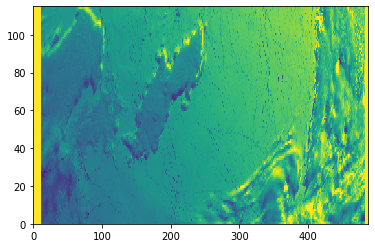

In [18]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        plt.pcolor(CNN_training[OLCI_file]['Oa18_radiance'][::10,::10],vmin=0,vmax=60)


**OLCI and SAR plotted on projection axes**

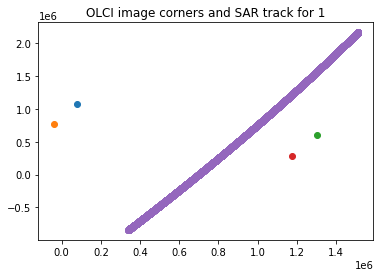

In [19]:
# OLCI and SAR coordinates are tilted wrt this projection coordinate system 
k=-1
for OLCI_file in OLCI_file_list:
    k=k+1
    OLCI_x=CNN_training[OLCI_file]['OLCI_x']
    OLCI_y=CNN_training[OLCI_file]['OLCI_y']
    OLCI_lon=CNN_training[OLCI_file]['OLCI_lon']    
    plt.title('OLCI image corners and SAR track for {}'.format(k+1))    
    plt.scatter(OLCI_x[0,0],OLCI_y[0,0])
    plt.scatter(OLCI_x[(np.shape(OLCI_lon)[0]-1),0],OLCI_y[(np.shape(OLCI_lon)[0]-1),0])
    plt.scatter(OLCI_x[0,(np.shape(OLCI_lon)[1]-1)],OLCI_y[0,(np.shape(OLCI_lon)[1]-1)])
    plt.scatter(OLCI_x[(np.shape(OLCI_lon)[0]-1),(np.shape(OLCI_lon)[1]-1)],OLCI_y[(np.shape(OLCI_lon)[0]-1),(np.shape(OLCI_lon)[1]-1)])
    plt.scatter(SAR_x,SAR_y)
    plt.show()

**Zooming in and viewing OLCI pixels in the vicinity of a SAR point**
- It is clear some of the SAR points are slightly offset from the OLCI image- every 8th point it drifts from the track, then returns 
- The OLCI pixel coordinates are not aligned with the coordinate system of the OLCI image 


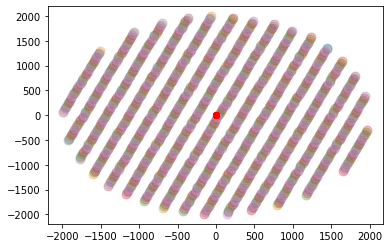

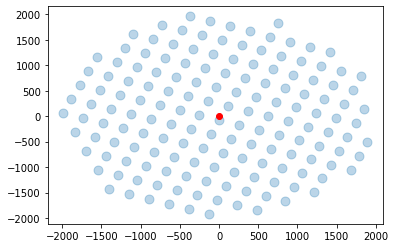

In [20]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks       
        match_indices_list=CNN_training[OLCI_file]['match_indices_list']
        OLCI_x_r=CNN_training[OLCI_file]['OLCI_x_r']
        OLCI_y_r=CNN_training[OLCI_file]['OLCI_y_r']
        SAR_x=CNN_training[OLCI_file]['SAR_x']
        SAR_y=CNN_training[OLCI_file]['SAR_y']
               
        N=5014
        for N in range(5014,5022):
            plt.scatter(OLCI_x_r[match_indices_list[N]]-SAR_x[N],OLCI_y_r[match_indices_list[N]]-SAR_y[N],s=80,alpha=0.3)
            plt.scatter(0,0,c=sig_0[N],marker="o",cmap='autumn',zorder=2)
        plt.show()
        
        N=5020
        for N in range(5019,5020):
            plt.scatter(OLCI_x_r[match_indices_list[N]]-SAR_x[N],OLCI_y_r[match_indices_list[N]]-SAR_y[N],s=80,alpha=0.3)
            plt.scatter(0,0,c=sig_0[N],marker="o",cmap='autumn',zorder=2)
        


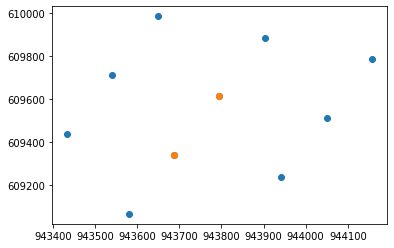

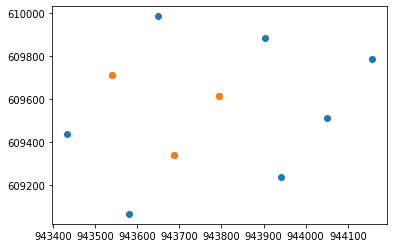

In [21]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        nearby_x=CNN_training[OLCI_file]['nearby_x']
        nearby_y=CNN_training[OLCI_file]['nearby_y']
        
        plt.scatter(nearby_x[5000][:10],nearby_y[5000][:10]) # plotting the 10 nearest OLCI points 
        plt.scatter(nearby_x[5000][:2],nearby_y[5000][:2])   # plotting the 2 nearest OLCI points
        plt.show()
        
        plt.scatter(nearby_x[5000][:10],nearby_y[5000][:10]) 
        plt.scatter(nearby_x[5000][:3],nearby_y[5000][:3])  
        plt.show()

        # in this case 2nd OLCI nearest neighbour is along flight and 3 is across flight 

**Colour plots of OLCI x and y coordinates**

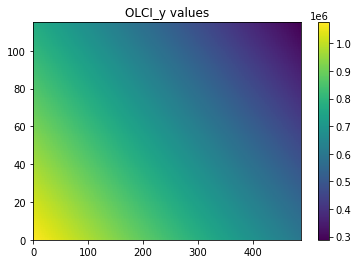

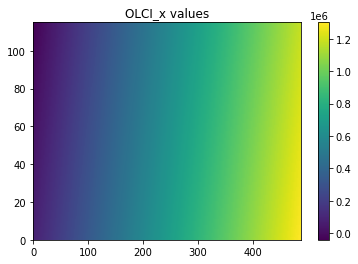

In [22]:
# plotting every 10 points of the x & y values of the OLCI array- can see they are not aligned with the image shape 
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[0]: # change this to look at other images/tracks
        OLCI_y=CNN_training[OLCI_file]['OLCI_y']
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']

        plt.title('OLCI_y values' )
        plt.pcolor(OLCI_y[::10,::10])
        plt.colorbar()
        plt.show()
              
        plt.title('OLCI_x values' )
        plt.pcolor(OLCI_x[::10,::10])
        plt.colorbar()
        plt.show()

**Colour plots of distances between consecutive OLCI pixels**
- Note that these plots are not using the projection axis 
- Axes are aligned with the OLCI pixel coordinates
- Can visually see approximate most common distance between OLCI points along and across track

In [23]:
for OLCI_file in OLCI_file_list: 
    if OLCI_file==OLCI_file_list[3]: # change this to look at other images/tracks
        OLCI_y=CNN_training[OLCI_file]['OLCI_y']
        OLCI_x=CNN_training[OLCI_file]['OLCI_x']

#         # np.roll performs cyclic shifting- check dimension it shift in 
#         print(OLCI_y)
#         print('')
#         # print(np.roll(OLCI_y,1,axis=0))
#         print(np.roll(OLCI_y,1,axis=1))

        # shifted by 1 in first dimension (along flight) direction
        OLCI_x_shift0=np.roll(OLCI_x,1,axis=0)
        OLCI_y_shift0=np.roll(OLCI_y,1,axis=0)

        # shifted by 1 in second (across flight) dimension direction 
        OLCI_x_shift1=np.roll(OLCI_x,1,axis=1)
        OLCI_y_shift1=np.roll(OLCI_y,1,axis=1)

        # arrays of the distances between consecutive OLCI pixels in 0 and 1 direction 
        d0=np.sqrt((OLCI_x_shift0-OLCI_x)**2.+(OLCI_y_shift0-OLCI_y)**2.)
        d1=np.sqrt((OLCI_x_shift1-OLCI_x)**2.+(OLCI_y_shift1-OLCI_y)**2.) 
        
        ###ALONG TRACK DISTANCES###
        
        print('Plots of distances (every 10) between consecutive OLCI pixels along track')
        plt.pcolor(d0[::10,::10])
        plt.colorbar()
        plt.show()
        
        plt.pcolor(d0[::10,::10],vmin=250,vmax=350)
        plt.colorbar()
        plt.show()
        # have some odd points and, a very large distance at the edge of plot since roll is taking away from end of the array
        
        plt.title('Histogram of along track distances between consecutive OLCI points along SAR track path')
        plt.hist(d0[:,3616].ravel(),range=(250, 350),bins=100) 
        plt.show()
        
        print('Along track distances between consecutive OLCI points along SAR track path:', d0[:,3616]) 
        print('Mean value:', np.mean(d0[1:,3616]))
        print('')
        
        ###ACROSS TRACK DISTANCES###
        
        print('Plots of distances (every 10) between consecutive OLCI pixels across track')
        plt.pcolor(d1[::10,::10])
        plt.colorbar()
        plt.show()

        plt.pcolor(d1[::10,::10],vmin=100,vmax=500)
        plt.colorbar()
        plt.show()
        # seems regular along SAR flight direction but a lot of distortion away from track (imager- side viewing)
        
        plt.title('Histogram of across track distances between consecutive OLCI points along SAR track path')
        plt.hist(d1[:,3616].ravel(),range=(100, 500),bins=100)
        plt.show()
        
        print('Across track distances between consecutive OLCI points along SAR track path:',d1[:,3616])
        print('Mean value:', np.mean(d1[:,3616]))

        

IndexError: list index out of range

## Data For CNN

In [24]:
from sklearn.model_selection import train_test_split

# As input, a CNN takes tensors of shape (image_height, image_width, color_channels)
# N is the number of training images, Nv is the number of validation images, Nt is the number of test images
# train_images=np.zeros((N,11,11,21)) 
# validation_images=np.zeros((Nv,11,11,20))
# test_images=np.zeros((Nt,11,11,20))
# train_labels=np.zeros((N))
# validation_labels=np.zeros((Nv))
# train_labels=np.zeros((Nt))


# no seperation between files 
images_n=[] # all 11x11 images (not array)
labels_n=[] # labels for 11x11 images (not array)
indices_n=[] # all SAR indices which correspond to 11x11 images 
files_n=[] # file number associated with each element in lists above 

# each element is for one file 
images_k=[]
labels_k=[]
indices_k=[]

n=-1
for OLCI_file in OLCI_file_list:
    n=n+1
    match_indices_list=CNN_training[OLCI_file]['match_indices_list'] 
    flag=CNN_training[OLCI_file]['flag']
    OLCI_data=CNN_training[OLCI_file]['OLCI_data']    
    SAR_lon=CNN_training[OLCI_file]['SAR_lon']
    # for each file 
    images_e=[] 
    labels_e=[]
    indices_e=[]     
    for i in range(np.size(SAR_lon)):
        if len(match_indices_list[i])>0:
            OLCI_closest=match_indices_list[i][0] # index of closest OLCI point to SAR point
            i0=index0[n][OLCI_closest]
            i1=index1[n][OLCI_closest]   
            image_temp=np.zeros((11,11,21))
            if OLCI_data[0][i0-5:i0+6,i1-5:i1+6].shape==(11,11):
                for r in range(1,22):            
                    image_temp[:,:,r-1]=OLCI_data[r-1][i0-5:i0+6,i1-5:i1+6]
                images_n.append(image_temp)   
                labels_n.append(flag[i])
                indices_n.append(i)
                files_n.append(n+1) # file naming starts from 1
                images_e.append(image_temp)   
                labels_e.append(flag[i])
                indices_e.append(i)                
    images_k.append(images_e)   
    labels_k.append(labels_e)
    indices_k.append(indices_e)
    
    
# each element is for one file- can use for checks
labels_k1=[]
images_k1=[]
indices_k1=[]
labels_k0=[]
images_k0=[]
indices_k0=[]   
for i in range(len(indices_k)):    
    labels_k_e=np.asarray(labels_k[i])
    images_k_e=np.asarray(images_k[i])
    indices_k_e=np.asarray(indices_k[i])
    
    labels_k1_e=labels_k_e[labels_k_e==1]
    images_k1_e=images_k_e[labels_k_e==1]
    indices_k1_e=indices_k_e[labels_k_e==1]
    labels_k0_e=labels_k_e[labels_k_e==0]
    images_k0_e=images_k_e[labels_k_e==0]
    indices_k0_e=indices_k_e[labels_k_e==0]
    
    labels_k1.append(labels_k1_e)
    images_k1.append(images_k1_e)
    indices_k1.append(indices_k1_e)
    labels_k0.append(labels_k0_e)
    images_k0.append(images_k0_e)
    indices_k0.append(indices_k0_e)


# turning lists into arrays 
images_n_a=np.asarray(images_n)
indices_n_a=np.asarray(indices_n)
labels_n_a=np.asarray(labels_n)
files_n_a=np.asarray(files_n)    

# using equal number of observations for each class
labels1=labels_n_a[labels_n_a==1.0]
labels0_a=labels_n_a[labels_n_a==0.0]
n=len(labels1)
labels0=labels0_a[:n]

images1=images_n_a[labels_n_a==1.0,:,:,:]
images0_a=images_n_a[labels_n_a==0.0,:,:,:]
images0=images0_a[:n]

indices1=indices_n_a[labels_n_a==1.0]
indices0_a=indices_n_a[labels_n_a==0.0]
indices0=indices0_a[:n]

files1=files_n_a[labels_n_a==1.0]
files0_a=files_n_a[labels_n_a==0.0]
files0=files0_a[:n]

# creating 50/50 lead/sea-ice datasets    
labels_cnn=np.concatenate((labels1,labels0))
files_cnn=np.concatenate((files1,files0))
indices_cnn=np.concatenate((indices1,indices0))
images_cnn=np.concatenate((images1,images0))
    
# ###SPLITTING INTO TRAINING, VALIDATION AND TESTING DATA###
# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time
train_images,validation_images,train_labels,validation_labels,train_indices,validation_indices,train_files,validation_files= train_test_split(images_cnn,labels_cnn,indices_cnn,files_cnn, test_size=0.5, random_state=42)
validation_images,test_images,validation_labels,test_labels,validation_indices,test_indices,validation_files,test_files= train_test_split(validation_images,validation_labels,validation_indices,validation_files, test_size=0.45, random_state=42)

In [25]:
# # checks
# for OLCI_file in OLCI_file_list: 
#     if OLCI_file==OLCI_file_list[3]: # change this to look at other images/tracks
#         flag=CNN_training[OLCI_file]['flag'] 
#         print(flag[4460:5000])

In [26]:
print('Number of lead samples:', len(labels1))
print('Number of sea-ice samples:', len(labels0))

Number of lead samples: 134
Number of sea-ice samples: 134


In [27]:
print('Shape of train images:', np.shape(train_images))
print('Shape of train labels:', len(train_labels))
print('Shape of train indices:', len(train_indices))
print('Shape of train files:', len(train_files))
print('')
print('Shape of validation images:', np.shape(validation_images))
print('Shape of validation labels:', len(validation_labels))
print('Shape of validation indices:', len(validation_indices))
print('Shape of validation files:', len(validation_files))
print('')
print('Shape of test images:', np.shape(test_images))
print('Shape of test labels:', len(test_labels))
print('Shape of test indices:', len(test_indices))
print('Shape of test files:', len(test_files))

Shape of train images: (134, 11, 11, 21)
Shape of train labels: 134
Shape of train indices: 134
Shape of train files: 134

Shape of validation images: (73, 11, 11, 21)
Shape of validation labels: 73
Shape of validation indices: 73
Shape of validation files: 73

Shape of test images: (61, 11, 11, 21)
Shape of test labels: 61
Shape of test indices: 61
Shape of test files: 61


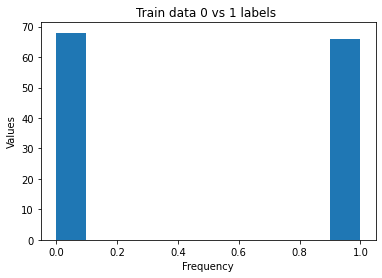

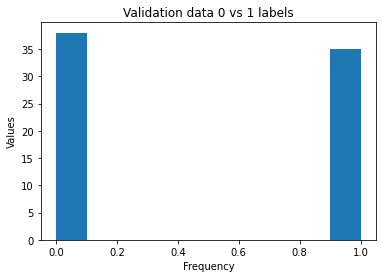

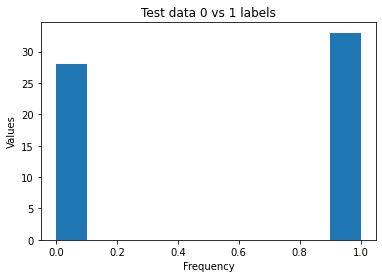

In [28]:
plt.title('Train data 0 vs 1 labels ')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.hist(train_labels)
plt.show()
plt.title('Validation data 0 vs 1 labels')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.hist(validation_labels)
plt.show()
plt.title('Test data 0 vs 1 labels')
plt.xlabel('Frequency')
plt.ylabel('Values')
plt.hist(test_labels)
plt.show()

In [29]:
print('Printing some values')
print('')
print('For train data:')
print('File:', train_files[0])
print('SAR_index:', train_indices[0])
print('Radiance band value:', train_images[0,10,10,20])
print('Label:', train_labels[0])
print('')
print('For validation data:')
print('File:', validation_files[0])
print('SAR_index:', validation_indices[0])
print('Radiance band value:', validation_images[0,10,10,20])
print('Label:', validation_labels[0])
print('')
print('For test data:')
print('File:', test_files[0])
print('SAR_index:', test_indices[0])
print('Radiance band value:', test_images[0,10,10,20])
print('Label:', test_labels[0])

Printing some values

For train data:
File: 1
SAR_index: 4942
Radiance band value: 27.31342315673828
Label: 1.0

For validation data:
File: 1
SAR_index: 5421
Radiance band value: 28.8724308013916
Label: 1.0

For test data:
File: 1
SAR_index: 4923
Radiance band value: 29.877197265625
Label: 1.0


Some train images


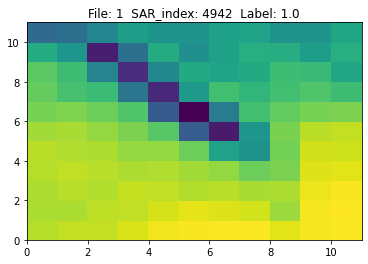

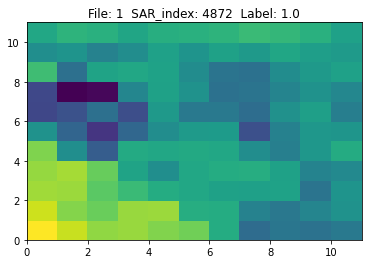

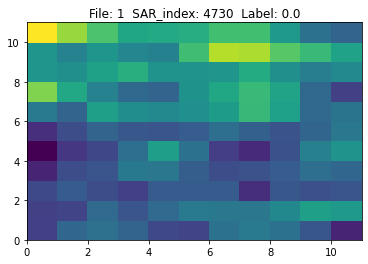

Some validation images


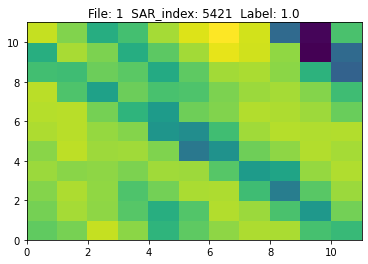

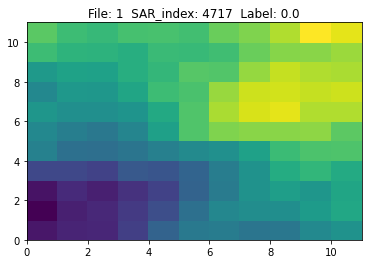

IndexError: index 100 is out of bounds for axis 0 with size 73

In [30]:
print('Some train images')
plt.title('File: {}  SAR_index: {}  Label: {}'.format(train_files[0], train_indices[0], train_labels[0]))
plt.pcolor(train_images[0,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(train_files[20], train_indices[20], train_labels[20]))
plt.pcolor(train_images[20,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(train_files[100], train_indices[100], train_labels[100]))
plt.pcolor(train_images[100,:,:,0])
plt.show()
print('Some validation images')
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[0], validation_indices[0], validation_labels[0]))
plt.pcolor(validation_images[0,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[20], validation_indices[20], validation_labels[20]))
plt.pcolor(validation_images[20,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[100], validation_indices[100], validation_labels[100]))
plt.pcolor(validation_images[100,:,:,0])
plt.show()
print('Some test images')
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[0], test_indices[0], test_labels[0]))
plt.pcolor(test_images[0,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[20], test_indices[20], test_labels[20]))
plt.pcolor(test_images[20,:,:,0])
plt.show()
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[100], test_indices[100], test_labels[100]))
plt.pcolor(test_images[100,:,:,0])
plt.show()

Looking at the image in the context of a large portion of the image to ensure it correct

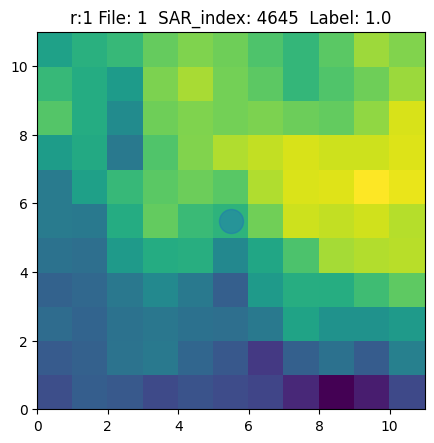

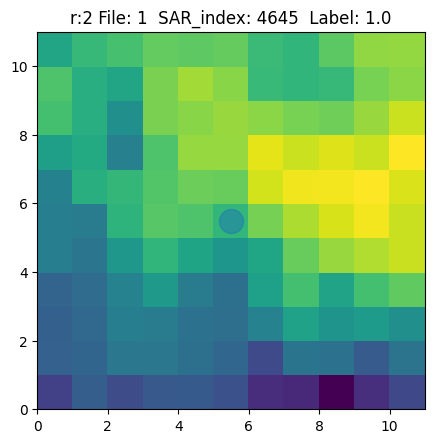

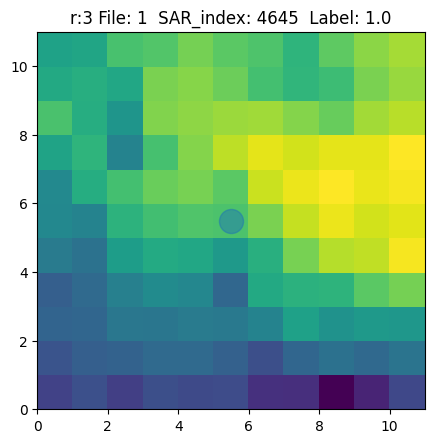

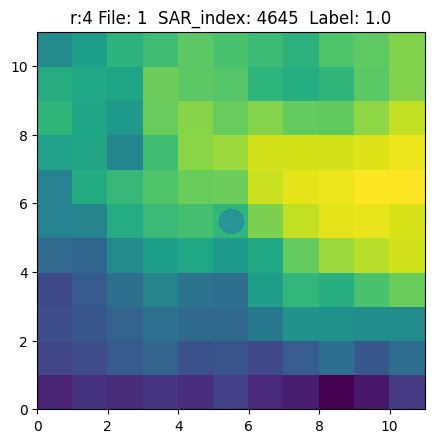

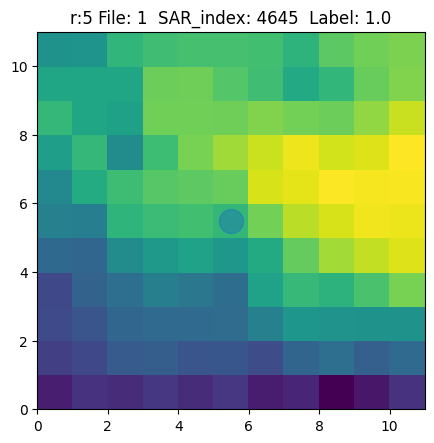

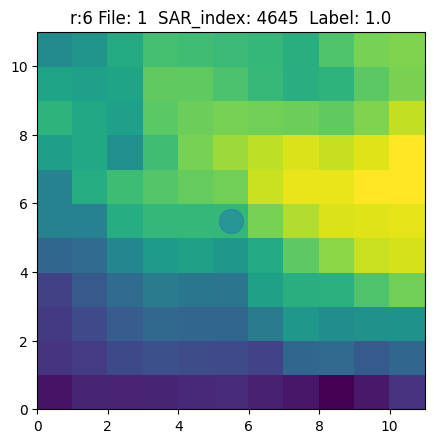

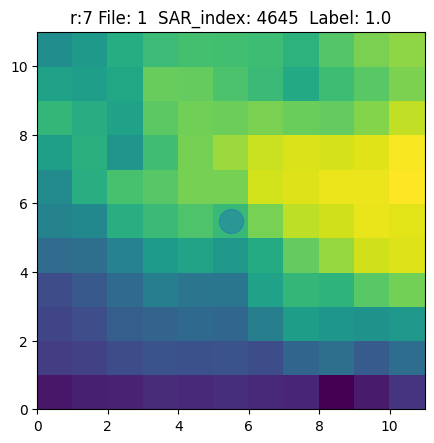

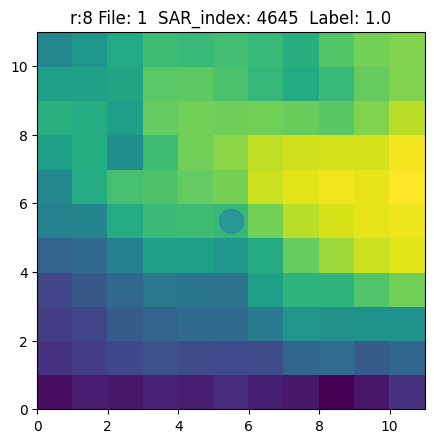

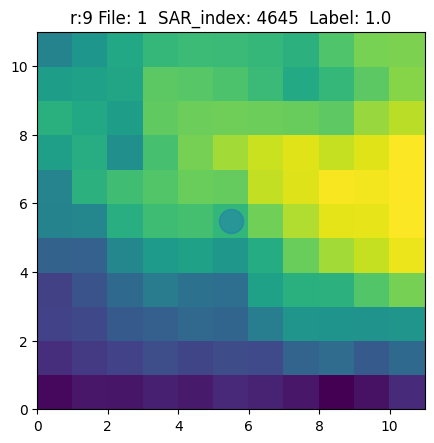

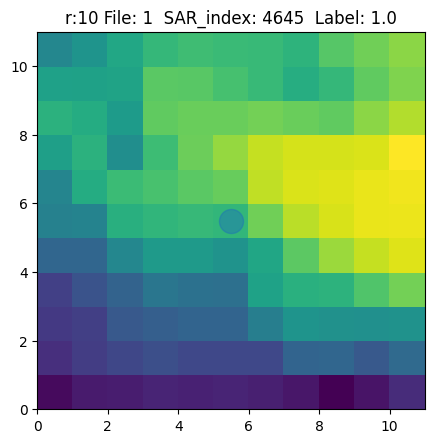

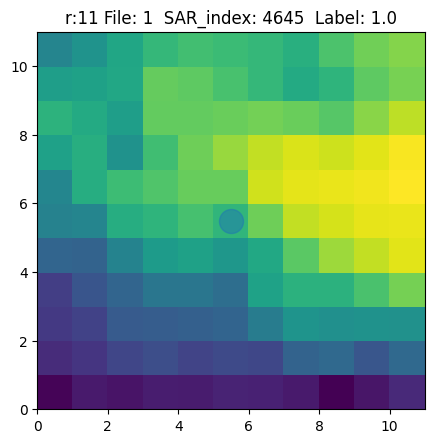

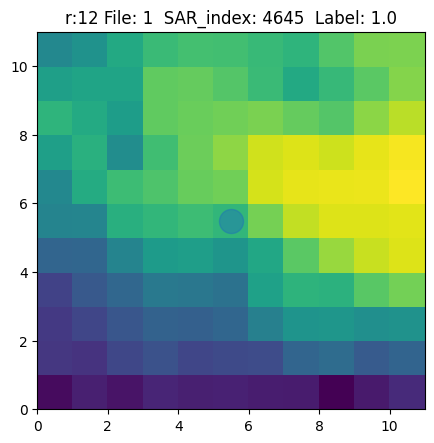

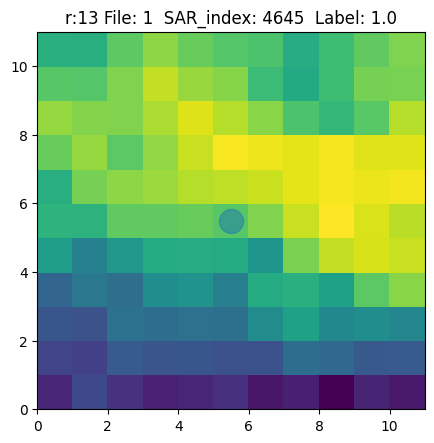

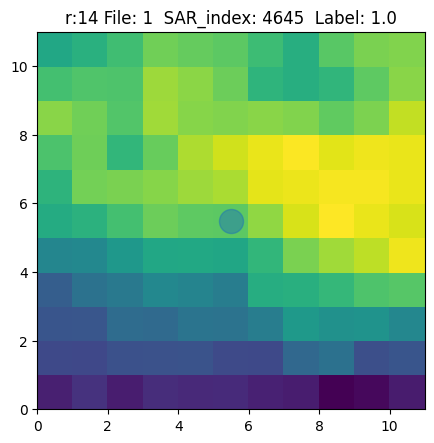

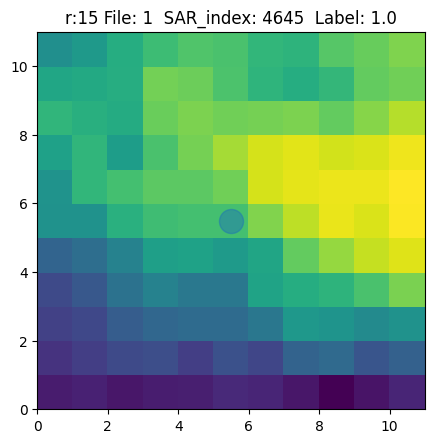

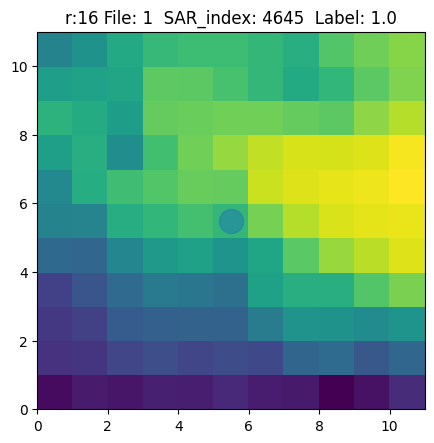

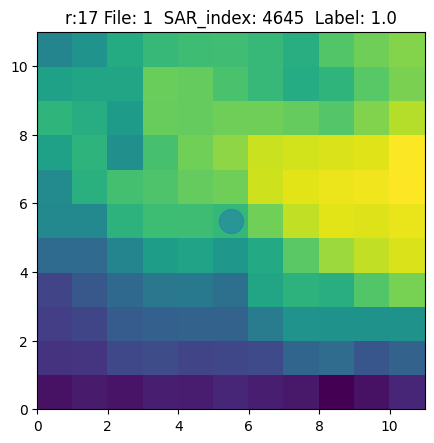

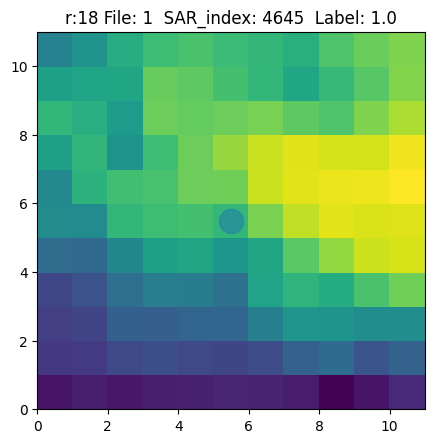

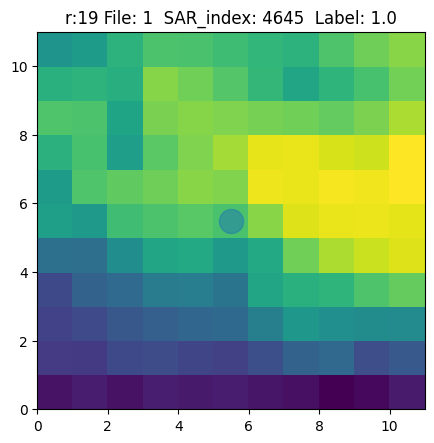

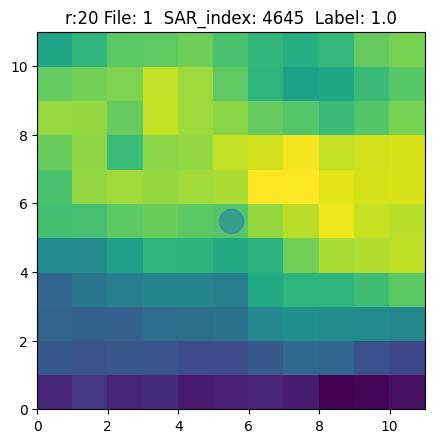

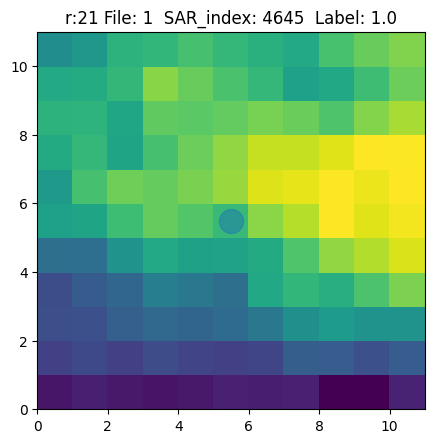

/Users/micheltsamados/miniconda3/envs/basemap_test/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


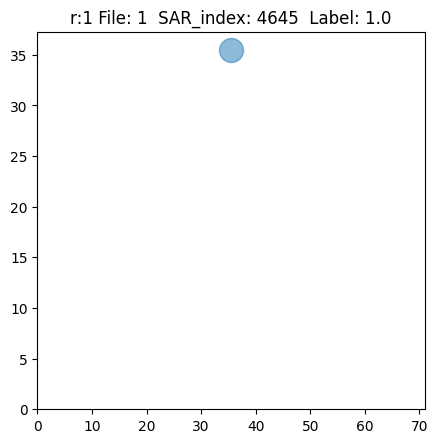

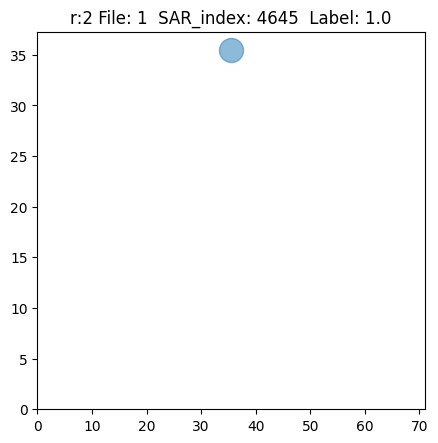

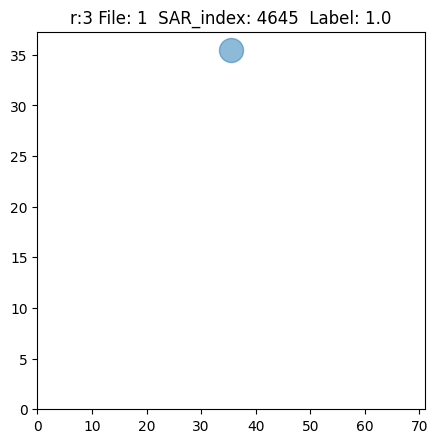

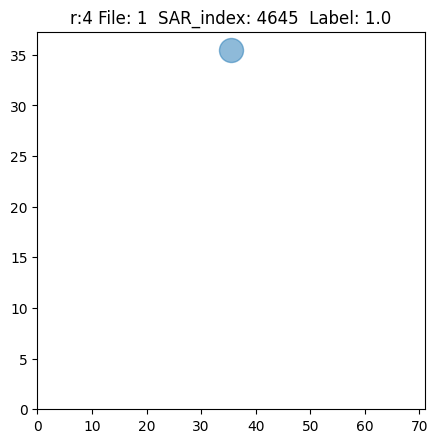

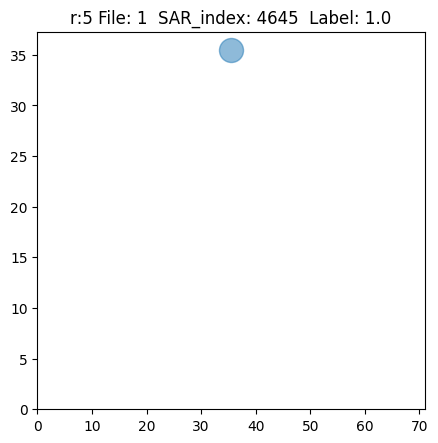

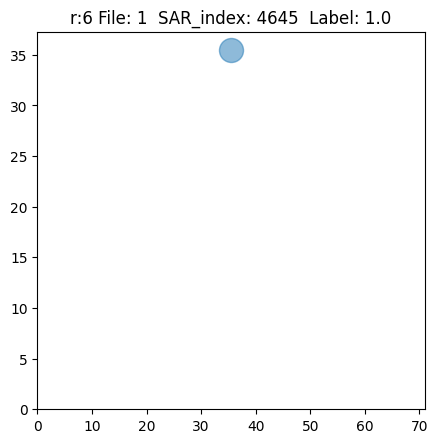

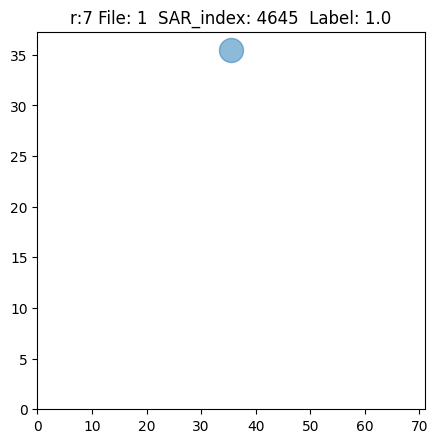

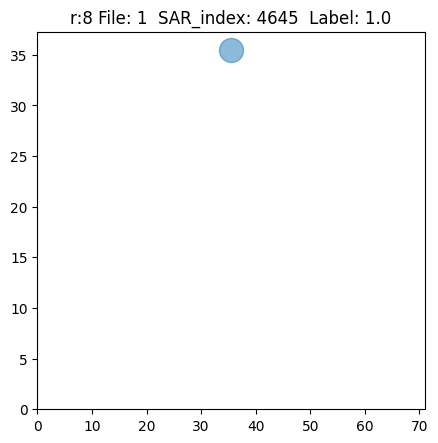

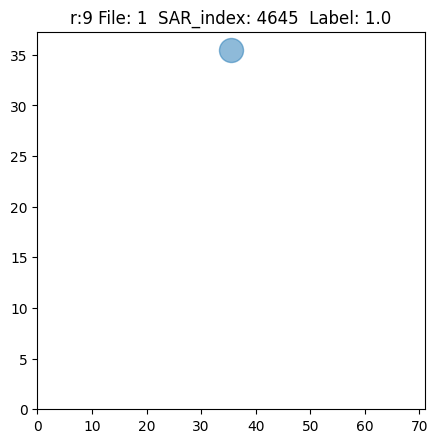

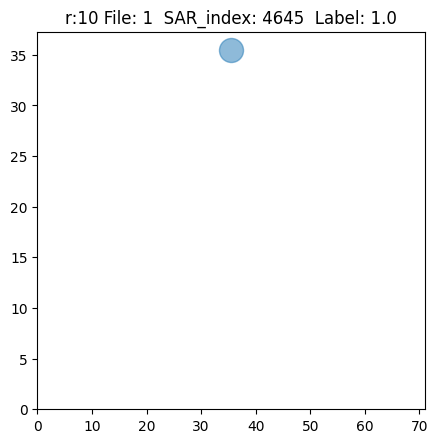

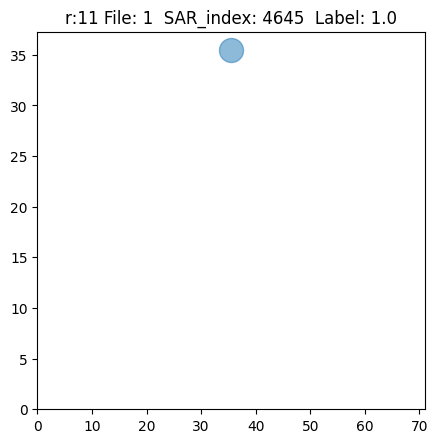

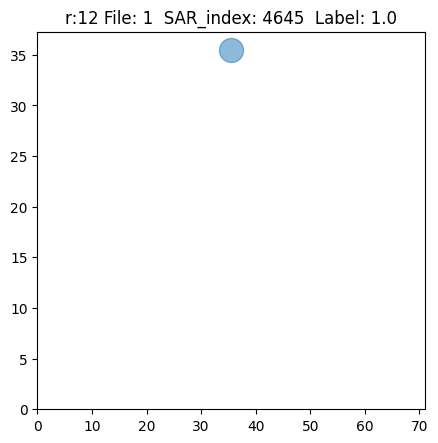

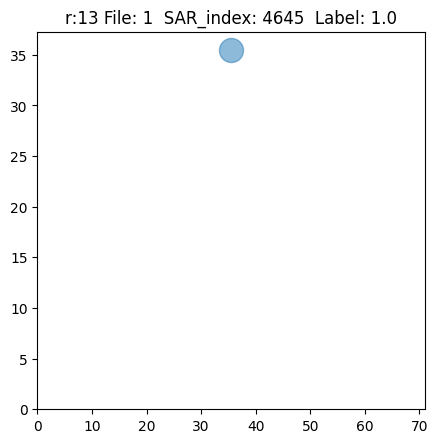

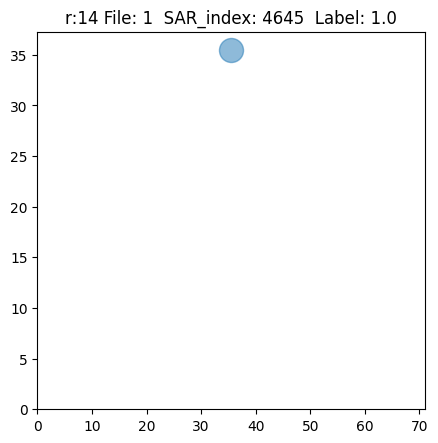

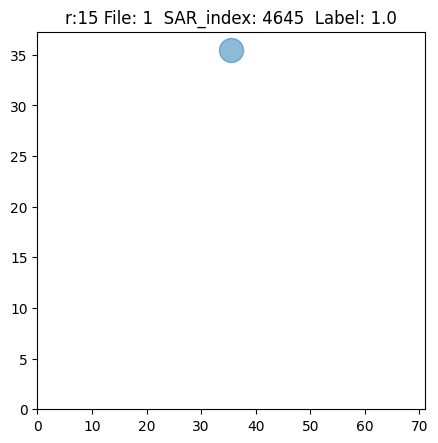

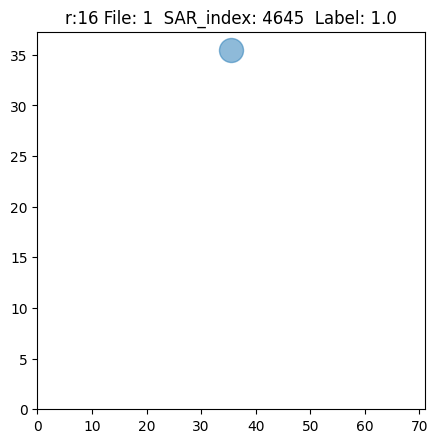

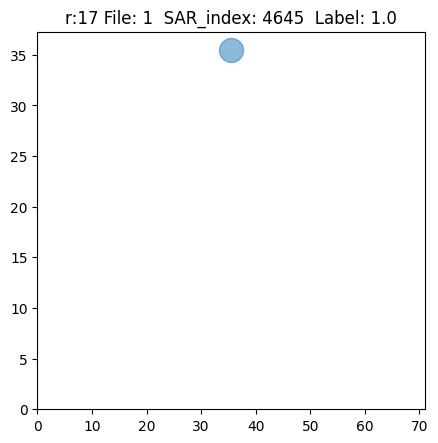

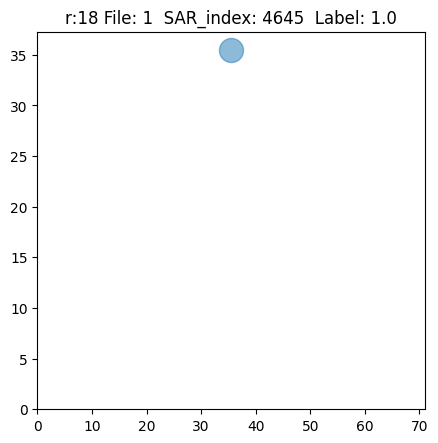

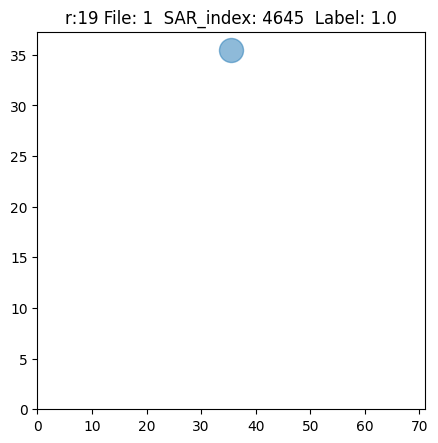

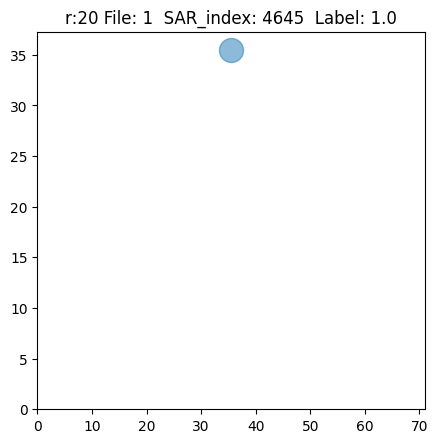

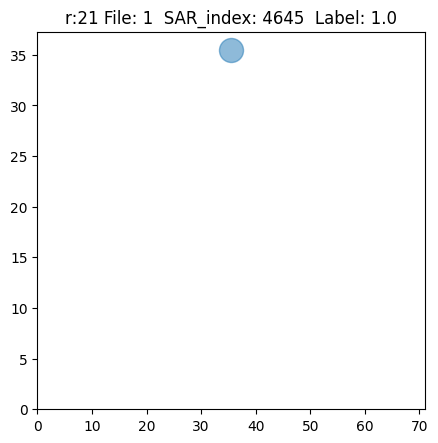

In [32]:
ntest=22

# plt.figure(figsize=(5,5),dpi=100)
# plt.pcolor(train_images[ntest,:,:,0])
# plt.scatter(5.5,5.5,s=300,alpha=0.1)

n0=train_indices[ntest]
nfile=train_files[ntest]

match_indices_list=CNN_training[OLCI_file_list[nfile-1]]['match_indices_list']
flag=CNN_training[OLCI_file_list[nfile-1]]['flag']
OLCI_data=CNN_training[OLCI_file_list[nfile-1]]['OLCI_data']
SAR_lon=CNN_training[OLCI_file_list[nfile-1]]['SAR_lon']
OLCI_closest=match_indices_list[n0][nfile-1] # index of closest OLCI point to SAR point
i0=index0[nfile-1][OLCI_closest]
i1=index1[nfile-1][OLCI_closest]

image_e=[]
for r in range(1,22):
    image_e.append(OLCI_data[r-1][i0-5:i0+6,i1-5:i1+6])
    plt.figure(figsize=(5,5),dpi=100)
    plt.title('r:{} File: {}  SAR_index: {}  Label: {}'.format(r, train_files[ntest], train_indices[ntest], train_labels[ntest]))
    plt.pcolor(OLCI_data[r-1][i0-5:i0+6,i1-5:i1+6])
    # plt.pcolor(image_e[3][:,:]/image_e[8][:,:])
    plt.scatter(5.5,5.5,s=300,alpha=0.5)

    plt.show()

image_e=[]
for r in range(1,22):
    image_e.append(OLCI_data[r-1][i0-35:i0+36,i1-35:i1+36])
    plt.figure(figsize=(5,5),dpi=100)
    plt.title('r:{} File: {}  SAR_index: {}  Label: {}'.format(r, train_files[ntest], train_indices[ntest], train_labels[ntest]))
    plt.pcolor(OLCI_data[r-1][i0-35:i0+36,i1-35:i1+36])
# plt.pcolor(image_e[3][:,:]/image_e[8][:,:])
    plt.scatter(35.5,35.5,s=300,alpha=0.5)

Looking at the distribution of radiance values for cenrtal pixels in training data classified as leads/sea-ice in order to determine whether the CNN would be able to distnguish them based on these features 

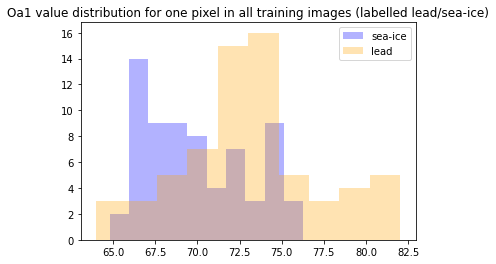

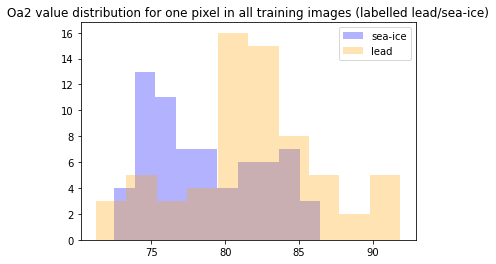

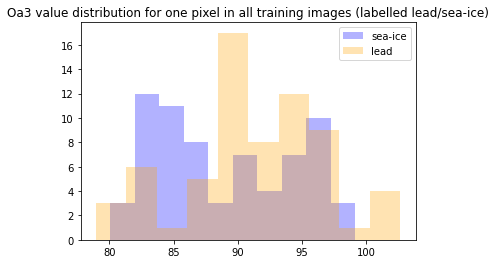

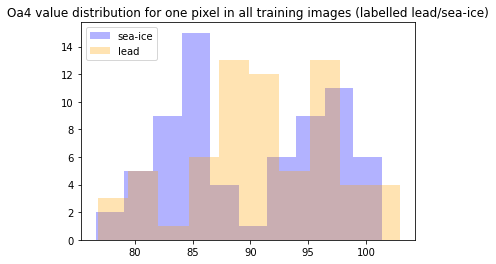

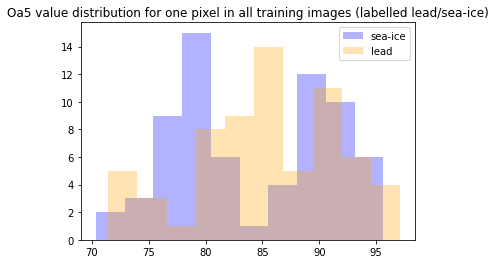

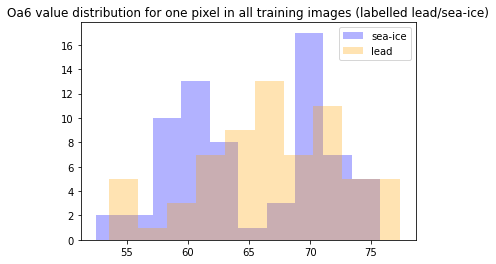

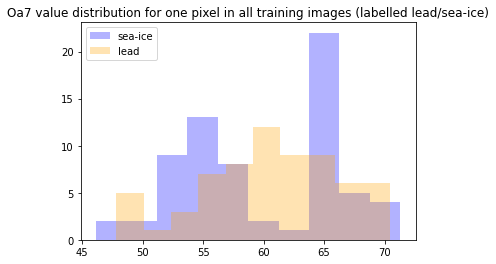

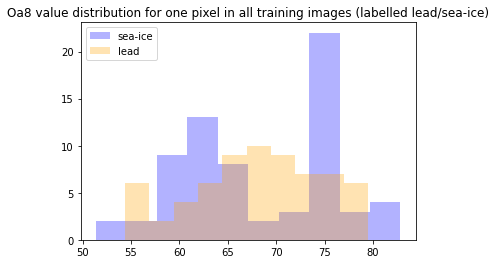

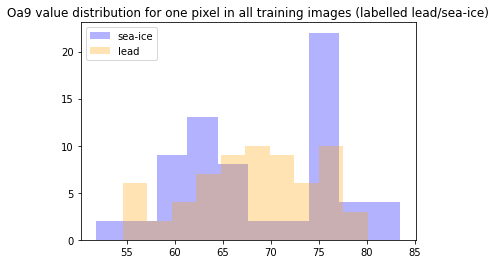

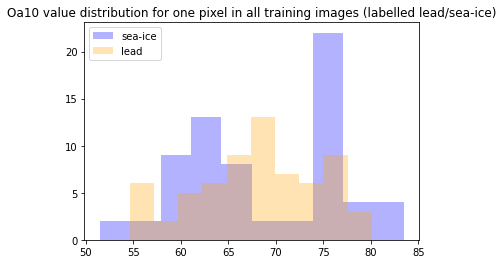

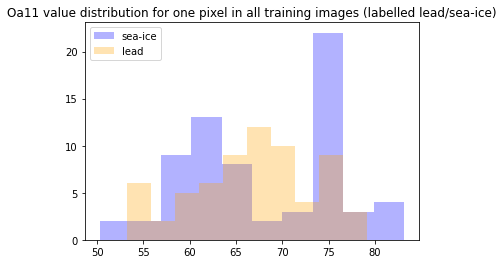

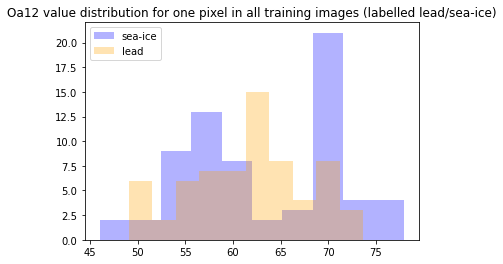

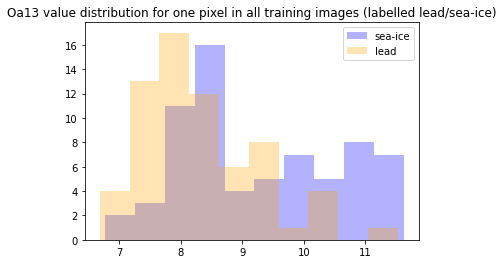

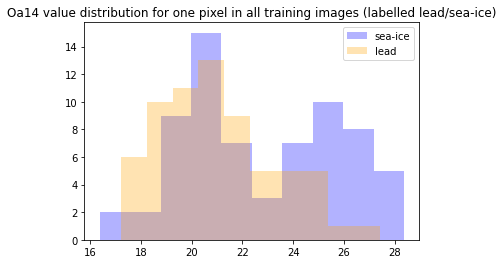

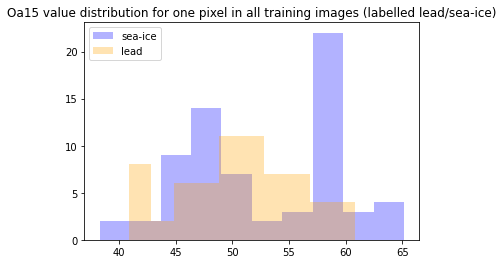

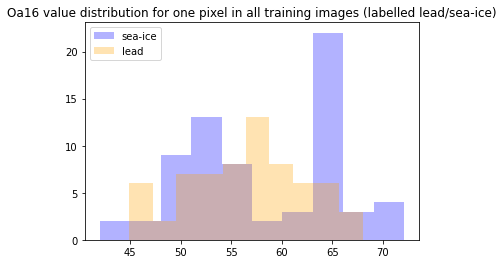

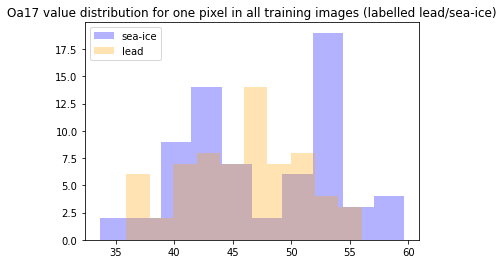

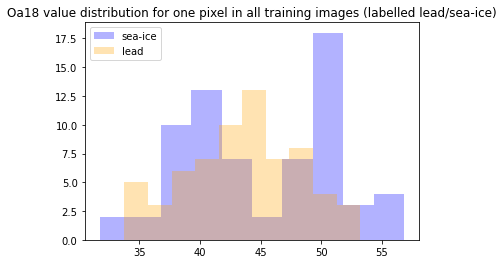

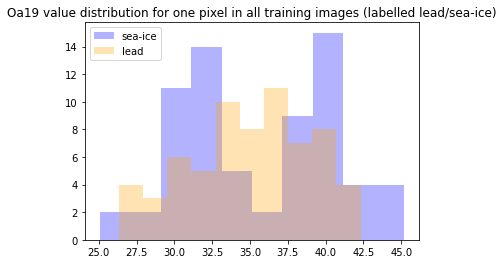

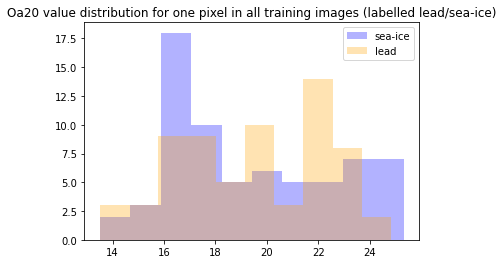

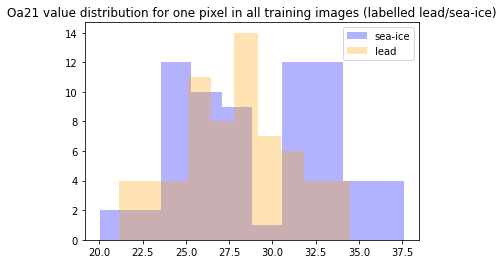

In [33]:
for r in range(21):
    plt.draw()
    plt.title('Oa{} value distribution for one pixel in all training images (labelled lead/sea-ice)'.format(r+1))
    plt.hist(train_images[train_labels==0,1,1,r],alpha=0.3, color = "blue", label='sea-ice')
    plt.hist(train_images[train_labels==1,1,1,r],alpha=0.3, color = "Orange", label='lead')
    plt.legend()
    plt.show()

#     plt.pause(0.001)
#     input("Press [enter] to continue.")


## Lead Detection CNN

In [34]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [35]:
# We know that the pixel values for each image in the dataset are unsigned integers 
# in the range between no color and full color, or 0 and 255

# Normalize pixel values to be between 0 and 1
train_images, validation_images = train_images / 255.0, validation_images / 255.0  # is this the same regardless of colour channels?

In [36]:
print('Shape of train images', np.shape(train_images))
print('Shape of train labels', np.shape(train_labels))
print('')
print('Shape of validation images', np.shape(validation_images))
print('Shape of validation labels', np.shape(validation_labels))
print('')
print('Shape of test images', np.shape(test_images))
print('Shape of test labels', np.shape(test_labels))

Shape of train images (134, 11, 11, 21)
Shape of train labels (134,)

Shape of validation images (73, 11, 11, 21)
Shape of validation labels (73,)

Shape of test images (61, 11, 11, 21)
Shape of test labels (61,)


### Create the convolutional base

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. In this case we have 21 colour channels corresponding to the 21 radiance bands. We will configure our CNN to process inputs of shape (11, 11, 21). We can do this by passing the argument `input_shape` to the first layer.


In [37]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(11, 11, 21)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))
# print(model.summary())

Above, we can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64) which tells us the number of 'filters/kernels/features' we are using. Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, we will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. We have 2 output classes (lead/no-lead), so we use a final Dense layer with 2 outputs.

In [38]:
model.add(layers.Flatten())
model.add(layers.Dense(44, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(2))

As you can see, the (1, 1, 64) outputs were flattened into vectors of shape (64) before going through two Dense layers.

In [39]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 32)          6080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 44)                2860      
_________________________________________________________________
dropout (Dropout)            (None, 44)                0

**Make sure to change the name of the saved model (i.e. currently run1.h5 in ModelCheckpoint below) so you don't overwrite an existing saved model**

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),   # could incorporate equivilant of from_logits=True to get 1 or 0 output 
              metrics=['accuracy'])

# Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the 
# model performance stops improving on a hold out validation dataset

# ReduleLROnPlateau reduces the learning rate

# The EarlyStopping callback will stop training once triggered, 
# but the model at the end of training may not be the model with best performance on the validation dataset
# additional callback is required that will save the best model observed during training for later use
# This is the ModelCheckpoint callback

callbacks=[
    EarlyStopping(monitor='val_loss', patience=7, mode='auto', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=5, mode='auto', min_lr=0.000001, verbose=1),
    ModelCheckpoint('run1.h5', monitor='val_accuracy', verbose=1,save_best_only=True, save_weights_only=False) # save_weights_only= False will save full model
]

# min_lr=0.000001

# I used a batch to give a smoother plot 
history = model.fit(train_images, train_labels, batch_size=30, epochs=1000, callbacks=callbacks,
                    validation_data=(validation_images, validation_labels))

Epoch 1/1000
5/5 [==============================] - 1s 90ms/step - loss: 1.8565 - accuracy: 0.5594 - val_loss: 0.6868 - val_accuracy: 0.5205

Epoch 00001: val_accuracy improved from -inf to 0.52055, saving model to run1.h5
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7479 - accuracy: 0.5045 - val_loss: 0.7269 - val_accuracy: 0.4795

Epoch 00002: val_accuracy did not improve from 0.52055
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7830 - accuracy: 0.4524 - val_loss: 0.6878 - val_accuracy: 0.4795

Epoch 00003: val_accuracy did not improve from 0.52055
Epoch 4/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.7141 - accuracy: 0.5334 - val_loss: 0.6980 - val_accuracy: 0.4795

Epoch 00004: val_accuracy did not improve from 0.52055
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.7226 - accuracy: 0.5245 - val_loss: 0.6866 - val_accuracy: 0.5205

Epoch 00005: val_accuracy did not improve from 0


Epoch 00042: val_accuracy did not improve from 0.52055
Epoch 43/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6526 - accuracy: 0.4220 - val_loss: 0.6285 - val_accuracy: 0.4110

Epoch 00043: val_accuracy did not improve from 0.52055
Epoch 44/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6410 - accuracy: 0.4222 - val_loss: 0.6262 - val_accuracy: 0.4521

Epoch 00044: val_accuracy did not improve from 0.52055
Epoch 45/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6554 - accuracy: 0.4889 - val_loss: 0.6207 - val_accuracy: 0.2055

Epoch 00045: val_accuracy did not improve from 0.52055
Epoch 46/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6362 - accuracy: 0.4895 - val_loss: 0.6187 - val_accuracy: 0.4247

Epoch 00046: val_accuracy did not improve from 0.52055
Epoch 47/1000
5/5 [==============================] - 0s 7ms/step - loss: 0.6327 - accuracy: 0.4011 - val_loss: 0.6086 - val_accuracy: 0.3562

Epoch 00047: v

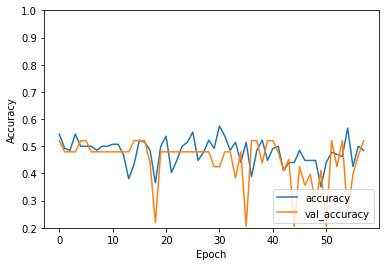

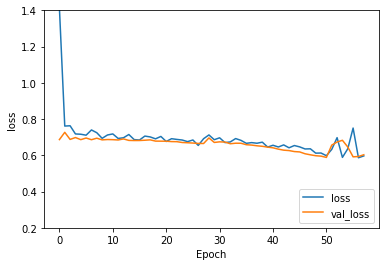

5/5 - 0s - loss: 0.6028 - accuracy: 0.5075
3/3 - 0s - loss: 0.6032 - accuracy: 0.5205


In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 1.4])
plt.legend(loc='lower right')
plt.show()

train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)
validation_loss, validation_acc = model.evaluate(validation_images,  validation_labels, verbose=2)

In [42]:
print('Acuracy')
print('train', train_acc)
print('validation', validation_acc)
print('')
print('loss')
print('train', train_loss)
print('validation', validation_loss)

#have overfitting problem 
# model would be overfitting if the training accuracy is more than the testing accuracy
# overfiting in terms of loss: if model has a low error in the training set and a higher error in the testing set 

Acuracy
train 0.5074626803398132
validation 0.5205479264259338

loss
train 0.602800190448761
validation 0.6031678915023804


**un-comment the boxes below and save the history and backup of the model if it is one you want to keep**

In [43]:
# # can save the model a second time as backup 
# model.save('run1_backup.h5') 

In [44]:
# # saving model history --> do this since .h5 does not save the callback history --> are required to plot the graphs
# import pandas as pd
# import json

# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 

# # save to json:  
# hist_json_file = 'run1_history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)

# # or save to csv: 
# hist_csv_file = 'run1_history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

**Quick look at how the model that just ran works for the unseen data. Note: this is not necessarily the 'saved model' that will be used.** 

In [45]:
# try the model that just ran 
# from tensorflow.keras.models import load_model
# saved_model = load_model('run1.h5')
# out = saved_model.predict(test_images)
out=model.predict(test_images)
print('Predicted test labels')
test_predictions=np.argmax(out,axis=1)
print(test_predictions)
print('')
print('Test labels')
test_labels_int=test_labels.astype(int)
print(test_labels_int)

test_labels_int=test_labels.astype(int)
match=[i for i, j in zip(test_predictions, test_labels_int) if i == j]
print('Number of elements in test_predictions and test_labels arrays:', len(test_labels))
print('Number of matching elements:', len(match))
print('Overall acuracy of CNN for test data:', len(match)/len(test_predictions) )

Predicted test labels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Test labels
[1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1
 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0]
Number of elements in test_predictions and test_labels arrays: 61
Number of matching elements: 28
Overall acuracy of CNN for test data: 0.45901639344262296


## Repeat Evaluation Experiments



**Merge the training and validation data again so that you can do a split in the loops below** Note: we are keeping the same testing data as before


In [46]:
print(np.shape(train_images))
print(np.shape(validation_images))
images_all=np.concatenate((train_images,validation_images))
labels_all=np.concatenate((train_labels,validation_labels))
indices_all=np.concatenate((train_indices,validation_indices))
files_all=np.concatenate((train_files,validation_files))
print(np.shape(images_all))
print(np.shape(labels_all))
print(np.shape(indices_all))
print(np.shape(files_all))
test_labels_int=test_labels.astype(int)
print(np.shape(test_images))
print(np.shape(test_labels))

(134, 11, 11, 21)
(73, 11, 11, 21)
(207, 11, 11, 21)
(207,)
(207,)
(207,)
(61, 11, 11, 21)
(61,)


**Fix the random seed and repeat the run through the layers 30 times** Note: random_state sets a seed to the random generator. In these runs we set random_state=42 in the train_test_split

In [47]:
# random seed fixed
train_loss_f=[]
train_acc_f=[]
validation_loss_f=[]
validation_acc_f=[]
overall_acc_f=[]


for i in range(30):
    train_images_r,validation_images_r,train_labels_r,validation_labels_r,train_indices_r,validation_indices_r,train_files_r,validation_files_r= train_test_split(images_all, labels_all, indices_all, files_all, test_size=0.5, random_state=42)
    train_images_r, validation_images_r = train_images_r / 255.0, validation_images_r / 255.0
    
    # create convolutional base
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(11, 11, 21)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # add dense layers 
    model.add(layers.Flatten())
    model.add(layers.Dense(44, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    
    # compiling the model 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),   
                  metrics=['accuracy'])

    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, mode='auto', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=5, mode='auto', min_lr=0.000001, verbose=1),
    ]

    model.fit(train_images_r, train_labels_r, batch_size=30, epochs=1000, callbacks=callbacks,
                        validation_data=(validation_images_r, validation_labels_r))
    
    # evaluate
    train_loss_r, train_acc_r = model.evaluate(train_images_r,  train_labels_r, verbose=2)
    validation_loss_r, validation_acc_r = model.evaluate(validation_images_r,  validation_labels_r, verbose=2)
    
    out = model.predict(test_images)
    test_predictions_r=np.argmax(out,axis=1)
    match=[i for i, j in zip(test_predictions_r, test_labels_int) if i == j]
    overall_accuracy_r=len(match)/len(test_predictions_r)
    overall_acc_f.append(overall_accuracy_r)
    
    train_loss_f.append(train_loss_r)
    train_acc_f.append(train_acc_r)
    validation_loss_f.append(validation_loss_r)
    validation_acc_f.append(validation_acc_r)

Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 3.9662 - accuracy: 0.5203 - val_loss: 1.7429 - val_accuracy: 0.5288
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.7183 - accuracy: 0.4997 - val_loss: 1.4663 - val_accuracy: 0.5288
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4361 - accuracy: 0.5430 - val_loss: 1.2886 - val_accuracy: 0.5288
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4657 - accuracy: 0.4381 - val_loss: 1.1469 - val_accuracy: 0.5288
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2503 - accuracy: 0.4203 - val_loss: 1.0286 - val_accuracy: 0.5288
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.0364 - accuracy: 0.5680 - val_loss: 0.9274 - val_accuracy: 0.5288
Epoch 7/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.9727 - accuracy: 0.5269 - val_loss: 0.8390 - val_accuracy: 0.5288
Epoch 8/1000
4/4 [=

4/4 [==============================] - 0s 10ms/step - loss: 0.9855 - accuracy: 0.5086 - val_loss: 0.9212 - val_accuracy: 0.4712
Epoch 14/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.9808 - accuracy: 0.5375 - val_loss: 0.8507 - val_accuracy: 0.4712
Epoch 15/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8533 - accuracy: 0.5347 - val_loss: 0.7887 - val_accuracy: 0.4712
Epoch 16/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7978 - accuracy: 0.6102 - val_loss: 0.7386 - val_accuracy: 0.4712
Epoch 17/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7685 - accuracy: 0.4936 - val_loss: 0.7065 - val_accuracy: 0.4712
Epoch 18/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7215 - accuracy: 0.5458 - val_loss: 0.6935 - val_accuracy: 0.4712
Epoch 19/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7026 - accuracy: 0.5197 - val_loss: 0.6960 - val_accuracy: 0.4712
Epoch 20/1000
4/4 [=======

Epoch 20/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6952 - accuracy: 0.5475 - val_loss: 0.6943 - val_accuracy: 0.4712
Epoch 21/1000
4/4 [==============================] - 0s 70ms/step - loss: 0.6904 - accuracy: 0.4697 - val_loss: 0.6946 - val_accuracy: 0.4712
Epoch 22/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7086 - accuracy: 0.5169 - val_loss: 0.6948 - val_accuracy: 0.4712

Epoch 00022: ReduceLROnPlateau reducing learning rate to 2.2500001068692655e-05.
Epoch 23/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6870 - accuracy: 0.5847 - val_loss: 0.6948 - val_accuracy: 0.4712
Epoch 24/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7220 - accuracy: 0.4875 - val_loss: 0.6948 - val_accuracy: 0.4712
Epoch 00024: early stopping
4/4 - 0s - loss: 0.6918 - accuracy: 0.5049
4/4 - 0s - loss: 0.6948 - accuracy: 0.4712
Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 4.0917 - accuracy: 0.4869

Epoch 13/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7624 - accuracy: 0.4753 - val_loss: 0.7047 - val_accuracy: 0.5288
Epoch 14/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7329 - accuracy: 0.5069 - val_loss: 0.6952 - val_accuracy: 0.5288
Epoch 15/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6891 - accuracy: 0.5397 - val_loss: 0.6961 - val_accuracy: 0.5288
Epoch 16/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7101 - accuracy: 0.5192 - val_loss: 0.6999 - val_accuracy: 0.5288
Epoch 17/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7019 - accuracy: 0.5214 - val_loss: 0.7013 - val_accuracy: 0.5288
Epoch 18/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7027 - accuracy: 0.4570 - val_loss: 0.6990 - val_accuracy: 0.5288
Epoch 19/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.6989 - accuracy: 0.4247 - val_loss: 0.6954 - val_accuracy: 0.5288

Epoch 00019:

4/4 [==============================] - 0s 9ms/step - loss: 1.7196 - accuracy: 0.4903 - val_loss: 1.4751 - val_accuracy: 0.4712
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.5671 - accuracy: 0.5475 - val_loss: 1.3834 - val_accuracy: 0.5288
Epoch 7/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4548 - accuracy: 0.4714 - val_loss: 1.3058 - val_accuracy: 0.5288
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2730 - accuracy: 0.5258 - val_loss: 1.2387 - val_accuracy: 0.5288
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3040 - accuracy: 0.5081 - val_loss: 1.1757 - val_accuracy: 0.5288
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2899 - accuracy: 0.4831 - val_loss: 1.1172 - val_accuracy: 0.5288
Epoch 11/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.1401 - accuracy: 0.5169 - val_loss: 1.0620 - val_accuracy: 0.5288
Epoch 12/1000
4/4 [============

4/4 [==============================] - 0s 9ms/step - loss: 1.1092 - accuracy: 0.5253 - val_loss: 1.0018 - val_accuracy: 0.5288
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.0830 - accuracy: 0.5425 - val_loss: 0.9103 - val_accuracy: 0.5288
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.9334 - accuracy: 0.5902 - val_loss: 0.8350 - val_accuracy: 0.5288
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8394 - accuracy: 0.4736 - val_loss: 0.7709 - val_accuracy: 0.5288
Epoch 10/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7756 - accuracy: 0.3809 - val_loss: 0.7224 - val_accuracy: 0.5288
Epoch 11/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7309 - accuracy: 0.4447 - val_loss: 0.6954 - val_accuracy: 0.5288
Epoch 12/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7038 - accuracy: 0.5780 - val_loss: 0.6946 - val_accuracy: 0.5288
Epoch 13/1000
4/4 [========

4/4 [==============================] - 0s 9ms/step - loss: 0.8051 - accuracy: 0.4936 - val_loss: 0.7544 - val_accuracy: 0.5288
Epoch 32/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8169 - accuracy: 0.4781 - val_loss: 0.7459 - val_accuracy: 0.5288
Epoch 33/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7561 - accuracy: 0.5125 - val_loss: 0.7376 - val_accuracy: 0.5288
Epoch 34/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7773 - accuracy: 0.5003 - val_loss: 0.7292 - val_accuracy: 0.5288
Epoch 35/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7379 - accuracy: 0.4986 - val_loss: 0.7217 - val_accuracy: 0.5288
Epoch 36/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7305 - accuracy: 0.5369 - val_loss: 0.7152 - val_accuracy: 0.5288
Epoch 37/1000
4/4 [==============================] - 0s 65ms/step - loss: 0.7228 - accuracy: 0.5136 - val_loss: 0.7095 - val_accuracy: 0.5288
Epoch 38/1000
4/4 [======

Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 6.2831 - accuracy: 0.4981 - val_loss: 4.5801 - val_accuracy: 0.5288
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.7112 - accuracy: 0.5114 - val_loss: 4.4398 - val_accuracy: 0.5288
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.6659 - accuracy: 0.5025 - val_loss: 4.3531 - val_accuracy: 0.5288
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.8220 - accuracy: 0.4769 - val_loss: 4.2904 - val_accuracy: 0.5288
Epoch 5/1000
4/4 [==============================] - 0s 10ms/step - loss: 4.5109 - accuracy: 0.5036 - val_loss: 4.2401 - val_accuracy: 0.5288
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.4859 - accuracy: 0.5003 - val_loss: 4.1973 - val_accuracy: 0.5288
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 4.5307 - accuracy: 0.4914 - val_loss: 4.1592 - val_accuracy: 0.5288
Epoch 8/1000
4/4 

Epoch 1/1000
4/4 [==============================] - 0s 40ms/step - loss: 3.7726 - accuracy: 0.4897 - val_loss: 1.8188 - val_accuracy: 0.5288
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.9716 - accuracy: 0.4753 - val_loss: 1.5406 - val_accuracy: 0.5288
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.7611 - accuracy: 0.4569 - val_loss: 1.3696 - val_accuracy: 0.5288
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3275 - accuracy: 0.4964 - val_loss: 1.2377 - val_accuracy: 0.4712
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3074 - accuracy: 0.5241 - val_loss: 1.1168 - val_accuracy: 0.4712
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.1502 - accuracy: 0.4625 - val_loss: 1.0098 - val_accuracy: 0.4712
Epoch 7/1000
4/4 [==============================] - 0s 11ms/step - loss: 1.0895 - accuracy: 0.5297 - val_loss: 0.9153 - val_accuracy: 0.4712
Epoch 8/1000
4/4 

Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.4057 - accuracy: 0.4908 - val_loss: 4.1677 - val_accuracy: 0.4712
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.0282 - accuracy: 0.4564 - val_loss: 4.1052 - val_accuracy: 0.4712
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.4068 - accuracy: 0.5075 - val_loss: 4.0535 - val_accuracy: 0.4712
Epoch 7/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.2549 - accuracy: 0.4964 - val_loss: 4.0149 - val_accuracy: 0.4712
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.4269 - accuracy: 0.5219 - val_loss: 3.9894 - val_accuracy: 0.4712
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.0752 - accuracy: 0.4819 - val_loss: 3.9798 - val_accuracy: 0.4712
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 4.5110 - accuracy: 0.5386 - val_loss: 3.9859 - val_accuracy: 0.4712
Epoch 11/1000
4/4 [

Epoch 15/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.9526 - accuracy: 0.5019 - val_loss: 0.8551 - val_accuracy: 0.4712
Epoch 16/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9415 - accuracy: 0.5231 - val_loss: 0.8166 - val_accuracy: 0.4712
Epoch 17/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8556 - accuracy: 0.5297 - val_loss: 0.7803 - val_accuracy: 0.4712
Epoch 18/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8008 - accuracy: 0.5086 - val_loss: 0.7499 - val_accuracy: 0.4712
Epoch 19/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7573 - accuracy: 0.4886 - val_loss: 0.7277 - val_accuracy: 0.4712
Epoch 20/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7513 - accuracy: 0.4842 - val_loss: 0.7130 - val_accuracy: 0.4712
Epoch 21/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7473 - accuracy: 0.5119 - val_loss: 0.7049 - val_accuracy: 0.4712
Epoch 22/1

Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.5755 - accuracy: 0.4858 - val_loss: 1.4340 - val_accuracy: 0.4712
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4826 - accuracy: 0.4908 - val_loss: 1.3111 - val_accuracy: 0.4712
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3637 - accuracy: 0.5103 - val_loss: 1.2082 - val_accuracy: 0.4712
Epoch 6/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.2015 - accuracy: 0.4764 - val_loss: 1.1167 - val_accuracy: 0.4712
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.1309 - accuracy: 0.4853 - val_loss: 1.0324 - val_accuracy: 0.4712
Epoch 8/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.0979 - accuracy: 0.4997 - val_loss: 0.9542 - val_accuracy: 0.4712
Epoch 9/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.9212 - accuracy: 0.4608 - val_loss: 0.8829 - val_accuracy: 0.4712
Epoch 10/1000
4/4

Epoch 1/1000
4/4 [==============================] - 0s 42ms/step - loss: 3.9235 - accuracy: 0.6097 - val_loss: 1.8770 - val_accuracy: 0.4712
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 2.0509 - accuracy: 0.5480 - val_loss: 1.6126 - val_accuracy: 0.4712
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.6550 - accuracy: 0.5086 - val_loss: 1.4584 - val_accuracy: 0.4712
Epoch 4/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.5506 - accuracy: 0.5108 - val_loss: 1.3404 - val_accuracy: 0.4712
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4152 - accuracy: 0.4753 - val_loss: 1.2421 - val_accuracy: 0.4712
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2507 - accuracy: 0.4692 - val_loss: 1.1531 - val_accuracy: 0.4712
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 1.2454 - accuracy: 0.4797 - val_loss: 1.0677 - val_accuracy: 0.4712
Epoch 8/1000
4/

4/4 [==============================] - 0s 10ms/step - loss: 0.6986 - accuracy: 0.4631 - val_loss: 0.6937 - val_accuracy: 0.4712
Epoch 26/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6968 - accuracy: 0.5208 - val_loss: 0.6936 - val_accuracy: 0.4712
Epoch 27/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.7127 - accuracy: 0.5253 - val_loss: 0.6935 - val_accuracy: 0.4712
Epoch 00027: early stopping
4/4 - 0s - loss: 0.6918 - accuracy: 0.5049
4/4 - 0s - loss: 0.6935 - accuracy: 0.4712
Epoch 1/1000
4/4 [==============================] - 0s 42ms/step - loss: 4.6391 - accuracy: 0.5153 - val_loss: 2.1011 - val_accuracy: 0.4712
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 2.1477 - accuracy: 0.4925 - val_loss: 1.8309 - val_accuracy: 0.4712
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.8800 - accuracy: 0.4858 - val_loss: 1.6475 - val_accuracy: 0.4712
Epoch 4/1000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 10ms/step - loss: 0.7068 - accuracy: 0.4053 - val_loss: 0.7000 - val_accuracy: 0.5288
Epoch 24/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.4675 - val_loss: 0.6993 - val_accuracy: 0.5288
Epoch 00024: early stopping
4/4 - 0s - loss: 0.6935 - accuracy: 0.4951
4/4 - 0s - loss: 0.6993 - accuracy: 0.5288
Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 3.6592 - accuracy: 0.4986 - val_loss: 1.8611 - val_accuracy: 0.4712
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 2.0616 - accuracy: 0.4969 - val_loss: 1.5436 - val_accuracy: 0.4712
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4617 - accuracy: 0.5602 - val_loss: 1.3382 - val_accuracy: 0.4712
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3630 - accuracy: 0.4658 - val_loss: 1.1741 - val_accuracy: 0.4712
Epoch 5/1000
4/4 [==============================] - 0s 

Epoch 1/1000
4/4 [==============================] - 0s 39ms/step - loss: 3.6031 - accuracy: 0.4909 - val_loss: 1.7673 - val_accuracy: 0.5288
Epoch 2/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.7786 - accuracy: 0.4420 - val_loss: 1.4604 - val_accuracy: 0.5288
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.4813 - accuracy: 0.5258 - val_loss: 1.2674 - val_accuracy: 0.5288
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.3525 - accuracy: 0.4359 - val_loss: 1.1168 - val_accuracy: 0.5288
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 1.2803 - accuracy: 0.5241 - val_loss: 0.9896 - val_accuracy: 0.5288
Epoch 6/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.8988 - accuracy: 0.5558 - val_loss: 0.8862 - val_accuracy: 0.5288
Epoch 7/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.9973 - accuracy: 0.4836 - val_loss: 0.7991 - val_accuracy: 0.5288
Epoch 8/1000
4/4 [

In [53]:
print('Random seed fixed and repeated run through the layers 30 times')
print('Mean training accuracy:', np.mean(train_acc_f))
print('Mean validation accuracy:', np.mean(validation_acc_f))
print('')
print('Mean training loss:', np.mean(train_loss_f))
print('Mean validation loss:', np.mean(validation_loss_f))
print('Overall accuracy:', np.mean(overall_acc_f))

Random seed fixed and repeated run through the layers 30 times
Mean training accuracy: 0.5209929118553798
Mean validation accuracy: 0.5249645411968231

Mean training loss: 0.7574666490157446
Mean validation loss: 0.7247437934080759
Overall accuracy: 0.4973236009732361


**Do not fix the random seed and repeat the run through the layers 30 times** Note: in these runs we do not set a random_state in the train_test_split

In [54]:
# random seed not fixed
train_loss_n=[]
train_acc_n=[]
validation_loss_n=[]
validation_acc_n=[]
overall_acc_n=[]


for i in range(30):
    train_images_r_n,validation_images_r_n,train_labels_r_n,validation_labels_r_n,train_indices_r_n,validation_indices_r_n,train_files_r_n,validation_files_r_n= train_test_split(images_all, labels_all, indices_all, files_all, test_size=0.5)
    train_images_r_n, validation_images_r_n = train_images_r_n / 255.0, validation_images_r_n / 255.0
    
    # create convolutional base
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(11, 11, 21)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # add dense layers 
    model.add(layers.Flatten())
    model.add(layers.Dense(44, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    
    # compiling the model 
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),   
                  metrics=['accuracy'])

    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, mode='auto', verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=5, mode='auto', min_lr=0.000001, verbose=1),
    ]

    model.fit(train_images_r_n, train_labels_r_n, batch_size=30, epochs=1000, callbacks=callbacks,
                        validation_data=(validation_images_r_n, validation_labels_r_n))

    
    # evaluate
    train_loss_r_n, train_acc_r_n = model.evaluate(train_images_r_n,  train_labels_r_n, verbose=2)
    validation_loss_r_n, validation_acc_r_n = model.evaluate(validation_images_r_n,  validation_labels_r_n, verbose=2)
    
    out = model.predict(test_images)
    test_predictions_r_n=np.argmax(out,axis=1)
    match=[i for i, j in zip(test_predictions_r_n, test_labels_int) if i == j]
    overall_accuracy_r_n=len(match)/len(test_predictions_r_n)
    overall_acc_n.append(overall_accuracy_r_n)
    
    train_loss_n.append(train_loss_r_n)
    train_acc_n.append(train_acc_r_n)
    validation_loss_n.append(validation_loss_r_n)
    validation_acc_n.append(validation_acc_r_n)

Epoch 1/1000
16/16 [==============================] - 1s 22ms/step - loss: 7.7708 - accuracy: 0.5077 - val_loss: 7.1874 - val_accuracy: 0.5340
Epoch 2/1000
16/16 [==============================] - 0s 12ms/step - loss: 7.9155 - accuracy: 0.4868 - val_loss: 7.1874 - val_accuracy: 0.5340
Epoch 3/1000
16/16 [==============================] - 0s 12ms/step - loss: 7.9365 - accuracy: 0.4855 - val_loss: 7.1874 - val_accuracy: 0.5340
Epoch 4/1000
16/16 [==============================] - 0s 13ms/step - loss: 8.3926 - accuracy: 0.4559 - val_loss: 7.1874 - val_accuracy: 0.5340
Epoch 5/1000
16/16 [==============================] - 0s 12ms/step - loss: 8.0688 - accuracy: 0.4769 - val_loss: 7.1874 - val_accuracy: 0.5340
Epoch 6/1000
16/16 [==============================] - 0s 12ms/step - loss: 7.8447 - accuracy: 0.4914 - val_loss: 7.1874 - val_accuracy: 0.5340

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 7/1000
16/16 [==============================] - 0s 11ms

16/16 [==============================] - 0s 10ms/step - loss: 0.6546 - accuracy: 0.5002 - val_loss: 0.6526 - val_accuracy: 0.5106
Epoch 29/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6488 - accuracy: 0.4736 - val_loss: 0.6441 - val_accuracy: 0.4915
Epoch 30/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6483 - accuracy: 0.4423 - val_loss: 0.6357 - val_accuracy: 0.4894
Epoch 31/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6364 - accuracy: 0.5080 - val_loss: 0.6349 - val_accuracy: 0.4894
Epoch 32/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6265 - accuracy: 0.5365 - val_loss: 0.6272 - val_accuracy: 0.4723
Epoch 33/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6130 - accuracy: 0.4806 - val_loss: 0.6077 - val_accuracy: 0.4894
Epoch 34/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.5921 - accuracy: 0.5261 - val_loss: 0.5912 - val_accuracy: 0.4745
Epoch 35/1

15/15 - 0s - loss: 0.3926 - accuracy: 0.1851
15/15 - 0s - loss: 0.4208 - accuracy: 0.1957
Epoch 1/1000
16/16 [==============================] - 1s 19ms/step - loss: 5.2880 - accuracy: 0.5125 - val_loss: 4.3838 - val_accuracy: 0.4936
Epoch 2/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.4860 - accuracy: 0.5123 - val_loss: 4.1615 - val_accuracy: 0.4936
Epoch 3/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.8414 - accuracy: 0.4545 - val_loss: 4.1517 - val_accuracy: 0.4936
Epoch 4/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.8103 - accuracy: 0.4481 - val_loss: 4.1484 - val_accuracy: 0.4936
Epoch 5/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.0164 - accuracy: 0.4767 - val_loss: 4.1457 - val_accuracy: 0.4936
Epoch 6/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.1754 - accuracy: 0.4967 - val_loss: 4.1450 - val_accuracy: 0.4936
Epoch 7/1000
16/16 [==============================] 

16/16 [==============================] - 0s 10ms/step - loss: 0.6847 - accuracy: 0.5347 - val_loss: 0.6786 - val_accuracy: 0.5277
Epoch 10/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6943 - accuracy: 0.5128 - val_loss: 0.6750 - val_accuracy: 0.5277
Epoch 11/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6876 - accuracy: 0.4553 - val_loss: 0.6794 - val_accuracy: 0.5277
Epoch 12/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6849 - accuracy: 0.5334 - val_loss: 0.6729 - val_accuracy: 0.5277
Epoch 13/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6783 - accuracy: 0.4820 - val_loss: 0.6720 - val_accuracy: 0.5277
Epoch 14/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6815 - accuracy: 0.5070 - val_loss: 0.6716 - val_accuracy: 0.5277
Epoch 15/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6747 - accuracy: 0.4688 - val_loss: 0.6686 - val_accuracy: 0.5277
Epoch 16/

16/16 [==============================] - 0s 10ms/step - loss: 0.3827 - accuracy: 0.3732 - val_loss: 0.3747 - val_accuracy: 0.1681
Epoch 67/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3849 - accuracy: 0.3670 - val_loss: 0.3847 - val_accuracy: 0.1617
Epoch 68/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4331 - accuracy: 0.4259 - val_loss: 0.4654 - val_accuracy: 0.2085
Epoch 69/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.5087 - accuracy: 0.3894 - val_loss: 0.4317 - val_accuracy: 0.1617
Epoch 70/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4012 - accuracy: 0.3976 - val_loss: 0.3818 - val_accuracy: 0.1681
Epoch 71/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3837 - accuracy: 0.3859 - val_loss: 0.3823 - val_accuracy: 0.1596

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 72/1000
16/16 [==============================] - 0s 10ms/step - lo

Epoch 49/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.0951 - accuracy: 0.4958 - val_loss: 3.9544 - val_accuracy: 0.5128
Epoch 50/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.0944 - accuracy: 0.4966 - val_loss: 3.9683 - val_accuracy: 0.5128
Epoch 51/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.1674 - accuracy: 0.4902 - val_loss: 3.9501 - val_accuracy: 0.5128
Epoch 52/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9976 - accuracy: 0.5072 - val_loss: 3.9416 - val_accuracy: 0.5128
Epoch 53/1000
16/16 [==============================] - 0s 9ms/step - loss: 3.8950 - accuracy: 0.5225 - val_loss: 3.9406 - val_accuracy: 0.5128
Epoch 54/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9842 - accuracy: 0.5097 - val_loss: 3.9400 - val_accuracy: 0.5128
Epoch 55/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.8483 - accuracy: 0.5280 - val_loss: 3.9437 - val_accuracy: 0.

16/16 [==============================] - 0s 10ms/step - loss: 0.4435 - accuracy: 0.6314 - val_loss: 0.4762 - val_accuracy: 0.6915
Epoch 38/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4478 - accuracy: 0.5897 - val_loss: 0.4434 - val_accuracy: 0.6085
Epoch 39/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4553 - accuracy: 0.5869 - val_loss: 0.4408 - val_accuracy: 0.6851
Epoch 40/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4457 - accuracy: 0.6784 - val_loss: 0.4357 - val_accuracy: 0.7170
Epoch 41/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4108 - accuracy: 0.6156 - val_loss: 0.4266 - val_accuracy: 0.7340
Epoch 42/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4300 - accuracy: 0.6563 - val_loss: 0.4428 - val_accuracy: 0.5915
Epoch 43/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4095 - accuracy: 0.5728 - val_loss: 0.4404 - val_accuracy: 0.5128
Epoch 4

Epoch 5/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6909 - accuracy: 0.4897 - val_loss: 0.6749 - val_accuracy: 0.4766
Epoch 6/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6842 - accuracy: 0.4870 - val_loss: 0.6728 - val_accuracy: 0.4936
Epoch 7/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6740 - accuracy: 0.4662 - val_loss: 0.6725 - val_accuracy: 0.5085
Epoch 8/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6782 - accuracy: 0.4895 - val_loss: 0.6696 - val_accuracy: 0.4553
Epoch 9/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6650 - accuracy: 0.4530 - val_loss: 0.6662 - val_accuracy: 0.5085
Epoch 10/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6757 - accuracy: 0.4781 - val_loss: 0.6648 - val_accuracy: 0.4936
Epoch 11/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6717 - accuracy: 0.4702 - val_loss: 0.6591 - val_accuracy: 0.25

16/16 [==============================] - 0s 10ms/step - loss: 0.6918 - accuracy: 0.4981 - val_loss: 0.6799 - val_accuracy: 0.4957
Epoch 6/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6918 - accuracy: 0.4726 - val_loss: 0.6803 - val_accuracy: 0.5043
Epoch 7/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6879 - accuracy: 0.5217 - val_loss: 0.6801 - val_accuracy: 0.5043
Epoch 8/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6967 - accuracy: 0.5044 - val_loss: 0.6796 - val_accuracy: 0.5043
Epoch 9/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6898 - accuracy: 0.4938 - val_loss: 0.6770 - val_accuracy: 0.6957
Epoch 10/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.4743 - val_loss: 0.6771 - val_accuracy: 0.5043
Epoch 11/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6801 - accuracy: 0.5258 - val_loss: 0.6760 - val_accuracy: 0.7596
Epoch 12/1000
1

Epoch 24/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6492 - accuracy: 0.4791 - val_loss: 0.6500 - val_accuracy: 0.5128
Epoch 25/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6532 - accuracy: 0.5221 - val_loss: 0.6450 - val_accuracy: 0.5128
Epoch 26/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6545 - accuracy: 0.5126 - val_loss: 0.6391 - val_accuracy: 0.5128
Epoch 27/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6405 - accuracy: 0.4423 - val_loss: 0.6323 - val_accuracy: 0.5128
Epoch 28/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6365 - accuracy: 0.5923 - val_loss: 0.6205 - val_accuracy: 0.5128
Epoch 29/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6203 - accuracy: 0.5119 - val_loss: 0.6079 - val_accuracy: 0.5128
Epoch 30/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6147 - accuracy: 0.5082 - val_loss: 0.5900 - val_accuracy: 0.5128

Epoch 5/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6961 - accuracy: 0.4650 - val_loss: 0.6782 - val_accuracy: 0.4745
Epoch 6/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6941 - accuracy: 0.4878 - val_loss: 0.6771 - val_accuracy: 0.4745
Epoch 7/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6855 - accuracy: 0.4628 - val_loss: 0.6762 - val_accuracy: 0.4745
Epoch 8/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.5036 - val_loss: 0.6772 - val_accuracy: 0.4745
Epoch 9/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6977 - accuracy: 0.4964 - val_loss: 0.6730 - val_accuracy: 0.4745
Epoch 10/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6934 - accuracy: 0.4677 - val_loss: 0.6746 - val_accuracy: 0.4745
Epoch 11/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.4956 - val_loss: 0.6701 - val_accuracy: 0.4745
Epo

16/16 [==============================] - 0s 9ms/step - loss: 0.4277 - accuracy: 0.5289 - val_loss: 0.4057 - val_accuracy: 0.8170
Epoch 47/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3809 - accuracy: 0.5477 - val_loss: 0.3864 - val_accuracy: 0.8255
Epoch 48/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3956 - accuracy: 0.5767 - val_loss: 0.4001 - val_accuracy: 0.7106
Epoch 49/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3726 - accuracy: 0.5599 - val_loss: 0.4117 - val_accuracy: 0.5191
Epoch 50/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4193 - accuracy: 0.5820 - val_loss: 0.3963 - val_accuracy: 0.5213
Epoch 51/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3980 - accuracy: 0.5831 - val_loss: 0.3875 - val_accuracy: 0.7489
Epoch 52/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4024 - accuracy: 0.5828 - val_loss: 0.3839 - val_accuracy: 0.8213
Epoch 53/10

Epoch 26/1000
16/16 [==============================] - 0s 15ms/step - loss: 3.8323 - accuracy: 0.4605 - val_loss: 4.0716 - val_accuracy: 0.4936
Epoch 27/1000
16/16 [==============================] - 0s 11ms/step - loss: 3.9354 - accuracy: 0.4760 - val_loss: 4.0577 - val_accuracy: 0.4936
Epoch 28/1000
16/16 [==============================] - 0s 11ms/step - loss: 4.1482 - accuracy: 0.5062 - val_loss: 4.0530 - val_accuracy: 0.4936
Epoch 29/1000
16/16 [==============================] - 0s 13ms/step - loss: 4.1008 - accuracy: 0.5016 - val_loss: 4.0409 - val_accuracy: 0.4936
Epoch 30/1000
16/16 [==============================] - 0s 12ms/step - loss: 3.7579 - accuracy: 0.4592 - val_loss: 4.0366 - val_accuracy: 0.4936
Epoch 31/1000
16/16 [==============================] - 0s 11ms/step - loss: 3.8681 - accuracy: 0.4740 - val_loss: 4.0423 - val_accuracy: 0.4936
Epoch 32/1000
16/16 [==============================] - 0s 13ms/step - loss: 3.8645 - accuracy: 0.4738 - val_loss: 4.0293 - val_accuracy:

16/16 [==============================] - 0s 11ms/step - loss: 3.7480 - accuracy: 0.4619 - val_loss: 3.8419 - val_accuracy: 0.4745
Epoch 73/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9967 - accuracy: 0.4931 - val_loss: 3.8479 - val_accuracy: 0.4745
Epoch 74/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.0798 - accuracy: 0.5032 - val_loss: 3.8405 - val_accuracy: 0.4745
Epoch 75/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9039 - accuracy: 0.4799 - val_loss: 3.8454 - val_accuracy: 0.4745
Epoch 76/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.2075 - accuracy: 0.5187 - val_loss: 3.8442 - val_accuracy: 0.4745
Epoch 77/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.1423 - accuracy: 0.5114 - val_loss: 3.8478 - val_accuracy: 0.4745
Epoch 78/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.4045 - accuracy: 0.5438 - val_loss: 3.8516 - val_accuracy: 0.4745
Epoch 7

Epoch 47/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.0755 - accuracy: 0.4999 - val_loss: 3.7861 - val_accuracy: 0.5362
Epoch 48/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.1882 - accuracy: 0.4838 - val_loss: 3.7934 - val_accuracy: 0.5362
Epoch 49/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.0129 - accuracy: 0.5084 - val_loss: 3.7990 - val_accuracy: 0.5362
Epoch 50/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9095 - accuracy: 0.5219 - val_loss: 3.7852 - val_accuracy: 0.5362
Epoch 51/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9985 - accuracy: 0.5073 - val_loss: 3.7853 - val_accuracy: 0.5362
Epoch 52/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9552 - accuracy: 0.5153 - val_loss: 3.7813 - val_accuracy: 0.5362
Epoch 53/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.1657 - accuracy: 0.4876 - val_loss: 3.7875 - val_accuracy: 

16/16 [==============================] - 0s 10ms/step - loss: 4.3782 - accuracy: 0.4664 - val_loss: 3.7913 - val_accuracy: 0.5426
Epoch 25/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.3802 - accuracy: 0.4644 - val_loss: 3.7880 - val_accuracy: 0.5426
Epoch 26/1000
16/16 [==============================] - 0s 10ms/step - loss: 3.9600 - accuracy: 0.5188 - val_loss: 3.7591 - val_accuracy: 0.5426
Epoch 27/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.2122 - accuracy: 0.4857 - val_loss: 3.7572 - val_accuracy: 0.5426
Epoch 28/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.2081 - accuracy: 0.4868 - val_loss: 3.7530 - val_accuracy: 0.5426
Epoch 29/1000
16/16 [==============================] - 0s 9ms/step - loss: 4.0677 - accuracy: 0.5013 - val_loss: 3.7504 - val_accuracy: 0.5426
Epoch 30/1000
16/16 [==============================] - 0s 10ms/step - loss: 4.3749 - accuracy: 0.4608 - val_loss: 3.7503 - val_accuracy: 0.5426
Epoch 31/

Epoch 20/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.6532 - accuracy: 0.4913 - val_loss: 0.6525 - val_accuracy: 0.5340
Epoch 21/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6537 - accuracy: 0.4943 - val_loss: 0.6480 - val_accuracy: 0.5340
Epoch 22/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6445 - accuracy: 0.5154 - val_loss: 0.6430 - val_accuracy: 0.6234
Epoch 23/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6423 - accuracy: 0.5699 - val_loss: 0.6369 - val_accuracy: 0.5340
Epoch 24/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.6454 - accuracy: 0.5020 - val_loss: 0.6283 - val_accuracy: 0.5340
Epoch 25/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6334 - accuracy: 0.4974 - val_loss: 0.6184 - val_accuracy: 0.5532
Epoch 26/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6053 - accuracy: 0.5171 - val_loss: 0.6057 - val_accuracy: 

16/16 [==============================] - 0s 9ms/step - loss: 0.4146 - accuracy: 0.3245 - val_loss: 0.3656 - val_accuracy: 0.1574
Epoch 133/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3933 - accuracy: 0.3362 - val_loss: 0.3646 - val_accuracy: 0.1574
Epoch 134/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3993 - accuracy: 0.3137 - val_loss: 0.3656 - val_accuracy: 0.1574
Epoch 135/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3722 - accuracy: 0.3189 - val_loss: 0.3647 - val_accuracy: 0.1574
Epoch 136/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.3806 - accuracy: 0.3147 - val_loss: 0.3654 - val_accuracy: 0.1574

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.3750000511645338e-06.
Epoch 137/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3746 - accuracy: 0.3085 - val_loss: 0.3651 - val_accuracy: 0.1574
Epoch 138/1000
16/16 [==============================] - 0s 10ms/ste

Epoch 50/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3933 - accuracy: 0.6569 - val_loss: 0.4456 - val_accuracy: 0.7979
Epoch 51/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3792 - accuracy: 0.6359 - val_loss: 0.4439 - val_accuracy: 0.7936
Epoch 52/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4160 - accuracy: 0.6154 - val_loss: 0.4406 - val_accuracy: 0.7957
Epoch 53/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3822 - accuracy: 0.7235 - val_loss: 0.4422 - val_accuracy: 0.7936
Epoch 54/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3600 - accuracy: 0.7082 - val_loss: 0.4464 - val_accuracy: 0.7809
Epoch 55/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3918 - accuracy: 0.6781 - val_loss: 0.4340 - val_accuracy: 0.7936
Epoch 56/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.3869 - accuracy: 0.6887 - val_loss: 0.4369 - val_accuracy:

16/16 [==============================] - 0s 10ms/step - loss: 1.0827 - accuracy: 0.4858 - val_loss: 0.7347 - val_accuracy: 0.5170
Epoch 3/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.7084 - accuracy: 0.5452 - val_loss: 0.6967 - val_accuracy: 0.5170
Epoch 4/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6896 - accuracy: 0.5145 - val_loss: 0.6807 - val_accuracy: 0.4830
Epoch 5/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6949 - accuracy: 0.4795 - val_loss: 0.6782 - val_accuracy: 0.4830
Epoch 6/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6927 - accuracy: 0.5352 - val_loss: 0.6764 - val_accuracy: 0.2191
Epoch 7/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6944 - accuracy: 0.5307 - val_loss: 0.6746 - val_accuracy: 0.4660
Epoch 8/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6887 - accuracy: 0.4964 - val_loss: 0.6726 - val_accuracy: 0.4809
Epoch 9/1000


16/16 [==============================] - 0s 10ms/step - loss: 0.3957 - accuracy: 0.1835 - val_loss: 0.3860 - val_accuracy: 0.1915
Epoch 60/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4066 - accuracy: 0.2139 - val_loss: 0.3870 - val_accuracy: 0.1660
Epoch 61/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4302 - accuracy: 0.2826 - val_loss: 0.3969 - val_accuracy: 0.2362
Epoch 62/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.4107 - accuracy: 0.2610 - val_loss: 0.3836 - val_accuracy: 0.1702
Epoch 63/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4418 - accuracy: 0.2697 - val_loss: 0.3864 - val_accuracy: 0.1638
Epoch 64/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.4224 - accuracy: 0.2573 - val_loss: 0.3869 - val_accuracy: 0.1617
Epoch 65/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.3928 - accuracy: 0.2275 - val_loss: 0.4080 - val_accuracy: 0.3596
Epoch 6

Epoch 27/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6612 - accuracy: 0.5105 - val_loss: 0.6557 - val_accuracy: 0.4894
Epoch 28/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6646 - accuracy: 0.5660 - val_loss: 0.6609 - val_accuracy: 0.4894
Epoch 29/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6542 - accuracy: 0.5212 - val_loss: 0.6492 - val_accuracy: 0.4936
Epoch 30/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6547 - accuracy: 0.4512 - val_loss: 0.6497 - val_accuracy: 0.4894
Epoch 31/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6418 - accuracy: 0.4703 - val_loss: 0.6438 - val_accuracy: 0.4894
Epoch 32/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6450 - accuracy: 0.5686 - val_loss: 0.6388 - val_accuracy: 0.4894
Epoch 33/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6633 - accuracy: 0.4882 - val_loss: 0.6335 - val_accuracy:

Epoch 83/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.3590 - accuracy: 0.3638 - val_loss: 0.3753 - val_accuracy: 0.2043
Epoch 00083: early stopping
15/15 - 0s - loss: 0.3835 - accuracy: 0.2021
15/15 - 0s - loss: 0.3753 - accuracy: 0.2043
Epoch 1/1000
16/16 [==============================] - 1s 19ms/step - loss: 2.9784 - accuracy: 0.4960 - val_loss: 1.3943 - val_accuracy: 0.5043
Epoch 2/1000
16/16 [==============================] - 0s 10ms/step - loss: 1.2415 - accuracy: 0.4590 - val_loss: 0.9457 - val_accuracy: 0.4957
Epoch 3/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.8382 - accuracy: 0.5315 - val_loss: 0.7014 - val_accuracy: 0.4957
Epoch 4/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.6862 - accuracy: 0.4793 - val_loss: 0.6813 - val_accuracy: 0.4957
Epoch 5/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6917 - accuracy: 0.4437 - val_loss: 0.6826 - val_accuracy: 0.4957
Epoch 6/1000
16/16 [====

Epoch 50/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.4196 - accuracy: 0.4607 - val_loss: 0.4074 - val_accuracy: 0.6277
Epoch 51/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4253 - accuracy: 0.4772 - val_loss: 0.4169 - val_accuracy: 0.4128
Epoch 52/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.4076 - accuracy: 0.5262 - val_loss: 0.4122 - val_accuracy: 0.5191
Epoch 53/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4210 - accuracy: 0.4385 - val_loss: 0.4090 - val_accuracy: 0.4723
Epoch 54/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4457 - accuracy: 0.4557 - val_loss: 0.4021 - val_accuracy: 0.4723
Epoch 55/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.4219 - accuracy: 0.5493 - val_loss: 0.4020 - val_accuracy: 0.5000
Epoch 56/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.4006 - accuracy: 0.4821 - val_loss: 0.3965 - val_accuracy: 0

16/16 [==============================] - 0s 9ms/step - loss: 0.6913 - accuracy: 0.4915 - val_loss: 0.6725 - val_accuracy: 0.4702
Epoch 9/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6810 - accuracy: 0.4510 - val_loss: 0.6715 - val_accuracy: 0.4702
Epoch 10/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6878 - accuracy: 0.5202 - val_loss: 0.6695 - val_accuracy: 0.4702
Epoch 11/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.6835 - accuracy: 0.5179 - val_loss: 0.6685 - val_accuracy: 0.4702
Epoch 12/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6890 - accuracy: 0.4760 - val_loss: 0.6695 - val_accuracy: 0.4702
Epoch 13/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6810 - accuracy: 0.4898 - val_loss: 0.6632 - val_accuracy: 0.4702
Epoch 14/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.6733 - accuracy: 0.5018 - val_loss: 0.6666 - val_accuracy: 0.4702
Epoch 15/1000

In [55]:
print('Random seed not fixed and repeated run through the layers 30 times')
print('Mean training accuracy:', np.mean(train_acc_n))
print('Mean validation accuracy:', np.mean(validation_acc_n))
print('')
print('Mean training loss:', np.mean(train_loss_n))
print('Mean validation loss:', np.mean(validation_loss_n))
print('')
print('Overall accuracy:', np.mean(overall_acc_n))

Random seed not fixed and repeated run through the layers 30 times
Mean training accuracy: 0.47021276752154034
Mean validation accuracy: 0.47063829799493156

Mean training loss: 1.9686117788155875
Mean validation loss: 1.9249046931664149

Overall accuracy: 0.5023114355231145


## Loading and Re-evaluating Saved CNN Model

In [56]:
# we want to load the saved model from file 
from tensorflow.keras.models import load_model
saved_model = load_model('my_model.h5')
# print(model.summary())

# # Opening model history JSON file
# f = open('my_model_history.json',) # this is the most recent one 
  
# # returns JSON object as a dictionary
# data = json.load(f)

In [57]:
# re-evaluate the saved model's performance on train and test data
loss, acc = saved_model.evaluate(train_images, train_labels, verbose=1)
print("Saved model accuracy on train data: {:5.2f}%".format(100 * acc))
print('')
loss, acc = saved_model.evaluate(validation_images, validation_labels, verbose=1)
print("Saved model accuracy on validation data: {:5.2f}%".format(100 * acc))
print('')
loss, acc = saved_model.evaluate(test_images, test_labels, verbose=1)
print("Saved model accuracy on test data: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 0s 2ms/step - loss: 0.2620 - accuracy: 0.8913
Saved model accuracy on train data: 89.13%

11/11 [==============================] - 0s 2ms/step - loss: 0.2614 - accuracy: 0.8979
Saved model accuracy on validation data: 89.79%

9/9 [==============================] - 0s 3ms/step - loss: 7.0124 - accuracy: 0.5401
Saved model accuracy on test data: 54.01%


## Evaluating the Saved CNN Saved Model Using Unseen Data

**Testing on the unseen testing data**

In [195]:
from tensorflow.keras.models import load_model

saved_model = load_model('my_model.h5')
out = saved_model.predict(test_images)
print('Predicted test labels')
test_predictions=np.argmax(out,axis=1)
print(test_predictions)
print('')
print('Test labels')
test_labels_int=test_labels.astype(int)
print(test_labels_int)
print('')
print('Number of elements in test_labels and test_predictions', len(test_labels))

Predicted test labels
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Test labels
[1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0
 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1
 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 

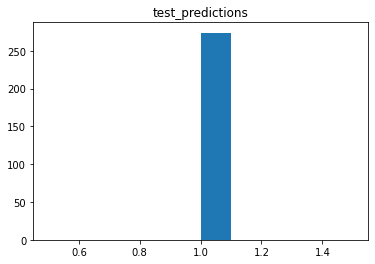

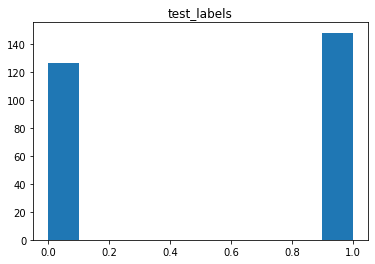

In [59]:
plt.title('test_predictions')
plt.hist(test_predictions)
plt.show()
plt.title('test_labels')
plt.hist(test_labels_int)
plt.show()

**User’s accuracy**= percentage of correctly classified samples in a class wrt all the samples classified as that class

In [60]:
test_predictions_1=[]
for i in range(len(test_predictions)):
    if test_predictions[i]==1:
        test_predictions_1.append(test_predictions[i])
print('Number of 1s in test_predictions:', len(test_predictions_1))

match=[i for i, j in zip(test_predictions, test_labels_int) if i == j==1]
print('Number of matching elements which are 1:', len(match))
print('User’s acuracy for lead detection in test data:', len(match)/len(test_predictions_1))

Number of 1s in test_predictions: 274
Number of matching elements which are 1: 148
User’s acuracy for lead detection in test data: 0.5401459854014599


In [61]:
test_predictions_0=[]
for i in range(len(test_predictions)):
    if test_predictions[i]==0:
        test_predictions_0.append(test_predictions[i])
print('Number of 0s in test_predictions:', len(test_predictions_0))

match=[i for i, j in zip(test_predictions, test_labels_int) if i == j==0]
print('Number of matching elements which are 0:', len(match))
print('User’s acuracy of sea-ice detection in test data:', len(match)/len(test_predictions_0))

Number of 0s in test_predictions: 0
Number of matching elements which are 0: 0


ZeroDivisionError: division by zero

**Producer’s accuracy**= percentage of correctly classified samples in a class wrt the number of reference samples in that class

In [62]:
test_labels_1=[]
for i in range(len(test_labels)):
    if test_labels[i]==1:
        test_labels_1.append(test_labels[i])
print('Number of 1s in test_labels:', len(test_labels_1))

match=[i for i, j in zip(test_predictions, test_labels_int) if i == j==1]
print('Number of matching elements which are 1:', len(match))
print('User’s acuracy for lead detection in test data:', len(match)/len(test_labels_1))

Number of 1s in test_labels: 148
Number of matching elements which are 1: 148
User’s acuracy for lead detection in test data: 1.0


In [63]:
test_labels_0=[]
for i in range(len(test_labels)):
    if test_labels[i]==0:
        test_labels_0.append(test_labels[i])
print('Number of 0s in test_labels:', len(test_labels_0))

match=[i for i, j in zip(test_predictions, test_labels_int) if i == j==0]
print('Number of matching elements which are 0:', len(match))
print('User’s acuracy of sea-ice detection in test data:', len(match)/len(test_labels_0))

Number of 0s in test_labels: 126
Number of matching elements which are 0: 0
User’s acuracy of sea-ice detection in test data: 0.0


**Overall accuracy**= total number of correctly classified samples wrt total number of reference sample

In [64]:
test_labels_int=test_labels.astype(int)
match=[i for i, j in zip(test_predictions, test_labels_int) if i == j]
print('Number of elements in test_predictions and test_labels arrays:', len(test_labels))
print('Number of matching elements:', len(match))
print('Overall acuracy of CNN for test data:', len(match)/len(test_predictions) )

Number of elements in test_predictions and test_labels arrays: 274
Number of matching elements: 148
Overall acuracy of CNN for test data: 0.5401459854014599


**False Positives**=number of falsely classified samples in a class wrt total number of samples classified as that class. Note it is: (1-user's accuracy)

In [188]:
test_predictions_1=[]
for i in range(len(test_predictions)):
    if test_predictions[i]==1:
        test_predictions_1.append(test_predictions[i])
print('Number of 1s in test_predictions:', len(test_predictions_1))

test_predictions_0=[]
for i in range(len(test_predictions)):
    if test_predictions[i]==0:
        test_predictions_0.append(test_predictions[i])
print('Number of 1s in test_predictions:', len(test_predictions_0))

match=[i for i, j in zip(test_predictions, test_labels_int) if (i==1 and j==0)]
print('Number of elements where test_predictions is 1 but test_labels is not:', len(match))
print('False positive lead percentage:', len(match)/len(test_predictions_1))
print('')
match=[i for i, j in zip(test_predictions, test_labels_int) if (i==0 and j==1)]
print('Number of elements where test_predictions is 0 but test_labels is not:', len(match))
print('False positive sea-ice percentage:', len(match)/len(test_predictions_0))

Number of 1s in test_predictions: 274
Number of 1s in test_predictions: 0
Number elements where test_predictions is 1 but test_labels is not (false positive): 126
False positive lead percentage: 0.45985401459854014

Number elements where test_predictions is 0 but test_labels is not (false negative) 0


ZeroDivisionError: division by zero

**False Negatives**=number of samples falsely not classified as class wrt total number of reference samples in that class. Note it is: (1-producer's accuracy)

In [204]:
test_labels_1=[]
for i in range(len(test_labels)):
    if test_labels[i]==1:
        test_labels_1.append(test_labels[i])
print('Number of 1s in test_labels:', len(test_labels_1))

test_labels_0=[]
for i in range(len(test_labels)):
    if test_labels[i]==0:
        test_labels_0.append(test_labels[i])
print('Number of 0s in test_labels:', len(test_labels_0))

match=[i for i, j in zip(test_predictions, test_labels_int) if (i==1 and j==0)]
print('Number of elements where test_predictions is 1 but test_labels is not:', len(match))
print('False negative sea-ice percentage:', len(match)/len(test_labels_0))
print('')
match=[i for i, j in zip(test_predictions, test_labels_int) if (i==0 and j==1)]
print('Number of elements where test_predictions is 0 but test_labels is not:', len(match))
print('False negative lead percentage:', len(match)/len(test_labels_1))

Number of 1s in test_labels: 148
Number of 0s in test_labels: 126
Number of elements where test_predictions is 1 but test_labels is not: 126
False negative sea-ice percentage: 1.0

Number of elements where test_predictions is 0 but test_labels is not: 0
False negative lead percentage: 0.0


**Finding the elements that do not match**

In [66]:
not_equal_elements_test=[]
for i in range(len(test_labels_int)):
    if test_labels_int[i]!=test_predictions[i]:
        not_equal_elements_test.append(i)
print('For test_predictions and test_labels')
print('Number of non-matching elements:', len(not_equal_elements_test))
print('Non-matching elements:', not_equal_elements_test)

For test_predictions and test_labels
Number of non-matching elements: 126
Non-matching elements: [1, 3, 6, 7, 10, 14, 16, 17, 18, 19, 21, 24, 25, 28, 30, 31, 34, 35, 37, 40, 47, 49, 51, 54, 56, 60, 65, 67, 69, 70, 71, 73, 74, 76, 80, 83, 84, 91, 92, 94, 97, 100, 103, 106, 108, 109, 111, 112, 113, 114, 117, 124, 126, 128, 129, 134, 137, 139, 140, 141, 142, 143, 145, 147, 148, 149, 150, 153, 155, 156, 158, 159, 161, 162, 165, 168, 169, 170, 171, 173, 176, 180, 181, 183, 184, 185, 187, 189, 192, 194, 197, 199, 206, 208, 209, 210, 211, 212, 216, 219, 221, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 241, 244, 245, 247, 249, 251, 252, 253, 255, 258, 263, 264, 268, 272, 273]


1
1.0


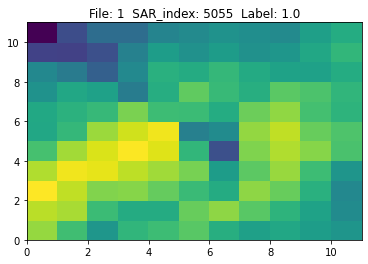

1
0.0


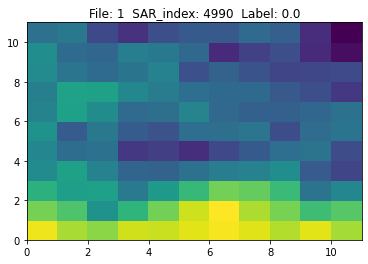

1
0.0


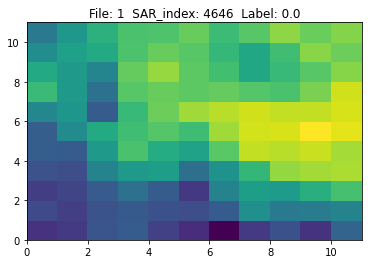

1
1.0


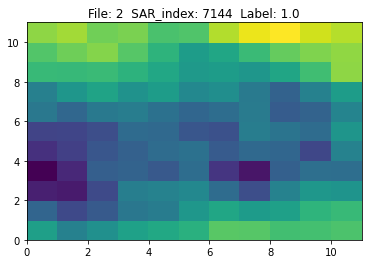

1
0.0


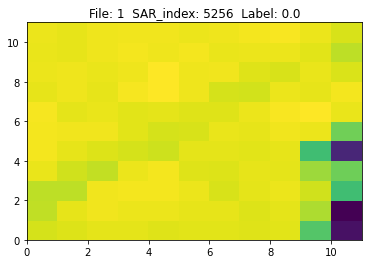

In [67]:
print(test_predictions[2])
print(test_labels[2])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[2], test_indices[2], test_labels[2]))
plt.pcolor(test_images[2,:,:,0])
plt.show()

print(test_predictions[7])
print(test_labels[7])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[7], test_indices[7], test_labels[7]))
plt.pcolor(test_images[7,:,:,0])
plt.show()

print(test_predictions[10])
print(test_labels[10])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[10], test_indices[10], test_labels[10]))
plt.pcolor(test_images[10,:,:,0])
plt.show()

print(test_predictions[220])
print(test_labels[220])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[220], test_indices[220], test_labels[220]))
plt.pcolor(test_images[220,:,:,0])
plt.show()

print(test_predictions[100])
print(test_labels[100])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[100], test_indices[100], test_labels[100]))
plt.pcolor(test_images[100,:,:,0])
plt.show()

# print(test_predictions[5])
# print(test_labels[5])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[5], test_indices[5], test_labels[5]))
# plt.pcolor(test_images[5,:,:,0])
# plt.show()

# print(test_predictions[60])
# print(test_labels[60])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[60], test_indices[60], test_labels[60]))
# plt.pcolor(test_images[60,:,:,0])
# plt.show()

# print(test_predictions[150])
# print(test_labels[150])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(test_files[150], test_indices[150], test_labels[150]))
# plt.pcolor(test_images[150,:,:,0])
# plt.show()

## Evaluating the CNN  Using Seen Data 

**Checking how it works for the validation data it has already seen**

In [196]:
from tensorflow.keras.models import load_model

saved_model = load_model('my_model.h5')
out = saved_model.predict(validation_images)
print('validation_prediction')
validation_predictions=np.argmax(out,axis=1)
print(validation_predictions)
print('')
print('validation_labels')
validation_labels_int=validation_labels.astype(int) 
print(validation_labels_int)
print('')
print('Number of elements in validation_labels and validation_predictions', len(validation_labels))

validation_prediction
[0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1
 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1
 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0
 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1
 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1
 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1]

validation_labels
[0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0
 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1

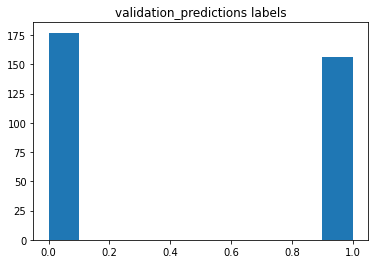

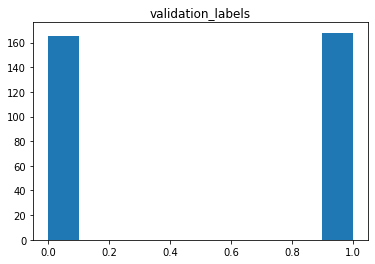

In [69]:
plt.title('validation_predictions labels')
plt.hist(validation_predictions)
plt.show()
plt.title('validation_labels')
plt.hist(validation_labels_int)
plt.show()

**User’s accuracy**= percentage of correctly classified samples in a class wrt all the samples classified as that class

In [70]:
validation_predictions_1=[]
for i in range(len(validation_predictions)):
    if validation_predictions[i]==1:
        validation_predictions_1.append(validation_predictions[i])
print('Number of 1s in validation_predictions:', len(validation_predictions_1))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if i== j==1]
print('Number of matching elements which are 1:', len(match))
print('User’s accuracy for lead detection in validation data:', len(match)/len(validation_predictions_1))

Number of 1s in validation_predictions: 156
Number of matching elements which are 1: 145
User’s accuracy for lead detection in validation data: 0.9294871794871795


In [71]:
validation_predictions_0=[]
for i in range(len(validation_predictions)):
    if validation_predictions[i]==0:
        validation_predictions_0.append(validation_predictions[i])
print('Number of 0s in validation_predictions:', len(validation_predictions_0))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if i == j==0]
print('Number of matching elements which are 0:', len(match))
print('User’s accuracy for sea-ice detection in validation data:', len(match)/len(validation_predictions_0))

Number of 0s in validation_predictions: 177
Number of matching elements which are 0: 154
User’s accuracy for sea-ice detection in validation data: 0.8700564971751412


**Producer’s accuracy**= percentage of correctly classified samples in a class wrt the number of reference samples in that class

In [72]:
validation_labels_1=[]
for i in range(len(validation_labels)):
    if validation_labels[i]==1:
        validation_labels_1.append(validation_labels[i])
print('Number of 1s in validation_labels:', len(validation_labels_1))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if i== j==1]
print('Number of matching elements which are 1:', len(match))
print('Producer’s accuracy for lead detection in validation data:', len(match)/len(validation_labels_1))

Number of 1s in validation_labels: 168
Number of matching elements which are 1: 145
Producer’s accuracy for lead detection in validation data: 0.8630952380952381


In [73]:
validation_labels_0=[]
for i in range(len(validation_labels)):
    if validation_labels[i]==0:
        validation_labels_0.append(validation_labels[i])
print('Number of 0s in validation_labels:', len(validation_labels_0))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if i == j==0]
print('Number of matching elements which are 0:', len(match))
print('Producer’s accuracy for sea-ice detection in validation data:', len(match)/len(validation_labels_0))

Number of 0s in validation_labels: 165
Number of matching elements which are 0: 154
Producer’s accuracy for sea-ice detection in validation data: 0.9333333333333333


**Overall accuracy**= total number of correctly classified samples wrt total number of reference sample

In [74]:
match=[i for i, j in zip(validation_predictions, validation_labels_int) if i == j]
print('Number of elements in  validation_predictions and validation_labels arrays:', len(validation_predictions))
print('Number of matching elements:', len(match))
print('Overall accuracy of CNN for validation data:', len(match)/len(validation_predictions))

Number of elements in  validation_predictions and validation_labels arrays: 333
Number of matching elements: 299
Overall accuracy of CNN for validation data: 0.8978978978978979


**False Positives**=number of falsely classified samples in a class wrt total number of samples classified as that class. Note it is: (1-user's accuracy)

In [202]:
validation_predictions_1=[]
for i in range(len(validation_predictions)):
    if validation_predictions[i]==1:
        validation_predictions_1.append(validation_predictions[i])
print('Number of 1s in validation_predictions:', len(validation_predictions_1))

validation_predictions_0=[]
for i in range(len(validation_predictions)):
    if validation_predictions[i]==0:
        validation_predictions_0.append(validation_predictions[i])
print('Number of 0s in validation_predictions:', len(validation_predictions_0))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if (i==1 and j==0)]
print('Number of elements where validation_predictions is 1 but validation_labels is not:', len(match))
print('False positive lead percentage:', len(match)/len(validation_predictions_1))
print('')
match=[i for i, j in zip(validation_predictions, validation_labels_int) if (i==0 and j==1)]
print('Number of elements where validation_predictions is 0 but validation_labels is not:', len(match))
print('False positive sea-ice percentage:', len(match)/len(validation_predictions_0))

Number of 1s in validation_predictions: 156
Number of 0s in validation_predictions: 177
Number of elements where validation_predictions is 1 but validation_labels is not: 11
False positive lead percentage: 0.07051282051282051

Number of elements where validation_predictions is 0 but validation_labels is not: 23
False positive sea-ice percentage: 0.12994350282485875


**False Negatives**=number of samples falsely not classified as class wrt total number of reference samples in that class. Note it is: (1-producer's accuracy)

In [203]:
validation_labels_1=[]
for i in range(len(validation_labels)):
    if validation_labels[i]==1:
        validation_labels_1.append(validation_labels[i])
print('Number of 1s in validation_labels:', len(validation_labels_1))

validation_labels_0=[]
for i in range(len(validation_labels)):
    if validation_labels[i]==0:
        validation_labels_0.append(validation_labels[i])
print('Number of 1s in validation_labels:', len(validation_labels_0))

match=[i for i, j in zip(validation_predictions, validation_labels_int) if (i==1 and j==0)]
print('Number of elements where validation_predictions is 1 but validation_labels is not:', len(match))
print('False negative sea-ice percentage:', len(match)/len(validation_labels_0))
print('')
match=[i for i, j in zip(validation_predictions, validation_labels_int) if (i==0 and j==1)]
print('Number of elements where validation_predictions is 0 but validation_labels is not:', len(match))
print('False negative lead percentage:', len(match)/len(validation_labels_1))

Number of 1s in validation_labels: 168
Number of 1s in validation_labels: 165
Number of elements where validation_predictions is 1 but validation_labels is not: 11
False negative sea-ice percentage: 0.06666666666666667

Number of elements where validation_predictions is 0 but validation_labels is not: 23
False negative lead percentage: 0.13690476190476192


**Finding the elements that do not match**

In [92]:
not_equal_elements_val=[]
validation_labels_no_match=[]
validation_predictions_no_match=[]
for i in range(len(validation_labels_int)):
    if validation_labels_int[i]!=validation_predictions[i]:
        not_equal_elements_val.append(i)
        validation_labels_no_match.append(validation_labels[i])
        validation_predictions_no_match.append(validation_predictions[i])
print('For validation_predictions and validation_labels')
print('Number of non-matching elements:', len(not_equal_elements_val))
print('Non-matching elements:', not_equal_elements_val)

For validation_predictions and validation_labels
Number of non-matching elements: 34
Non-matching elements: [3, 5, 33, 44, 64, 67, 72, 75, 95, 115, 118, 126, 127, 128, 135, 138, 141, 185, 195, 208, 210, 233, 252, 255, 256, 265, 267, 274, 279, 291, 302, 317, 319, 328]


**Visually look at images that do not match**

0
1.0


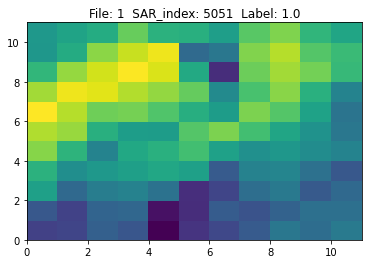

0
1.0


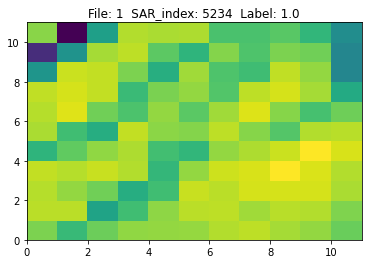

1
0.0


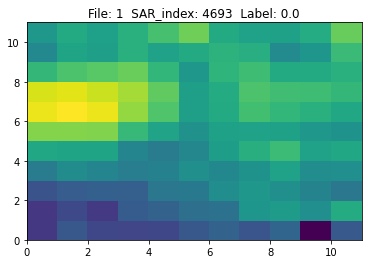

0
1.0


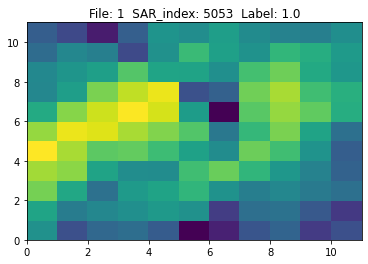

0
1.0


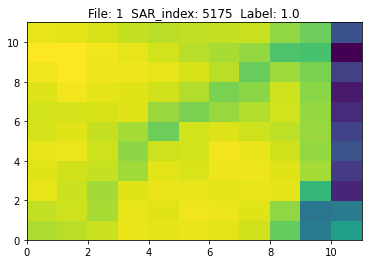

0
1.0


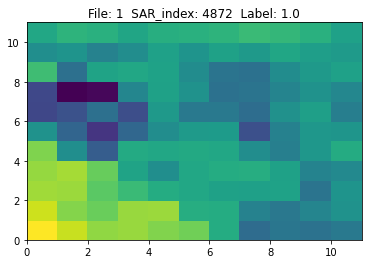

1
0.0


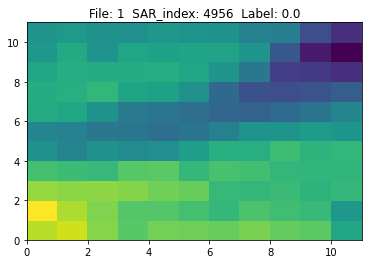

0
1.0


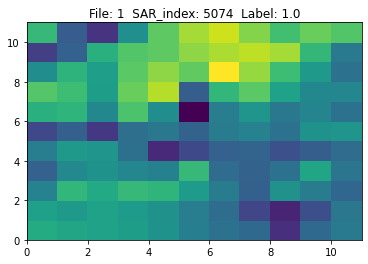

0
1.0


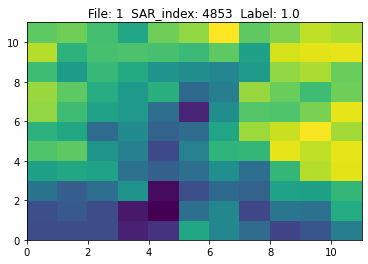

0
1.0


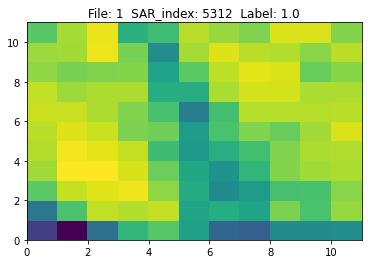

0
1.0


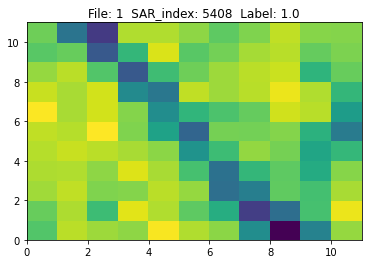

0
1.0


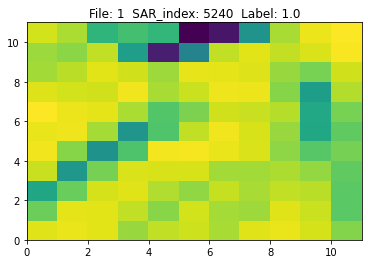

1
0.0


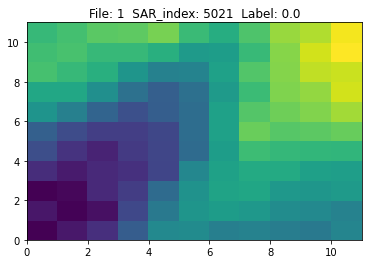

0
1.0


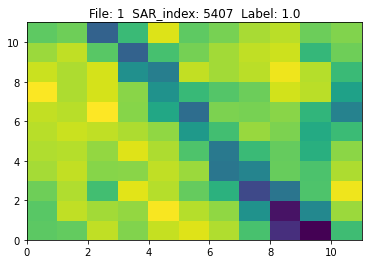

1
0.0


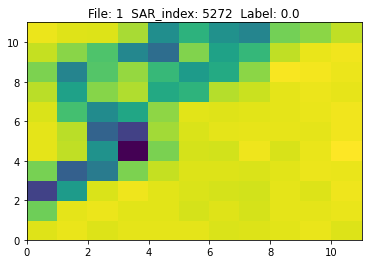

1
0.0


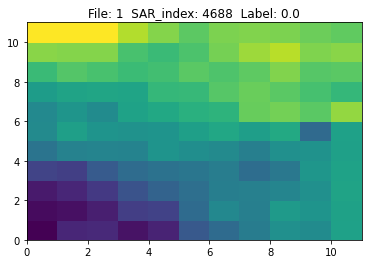

1
0.0


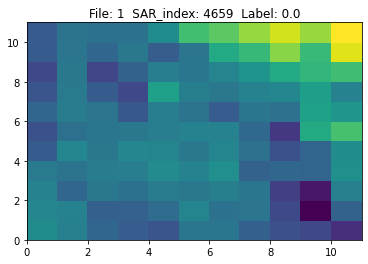

0
1.0


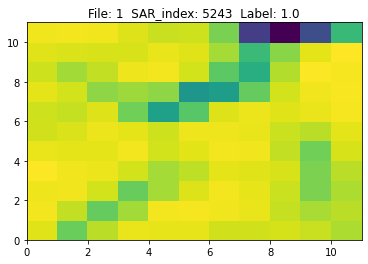

0
1.0


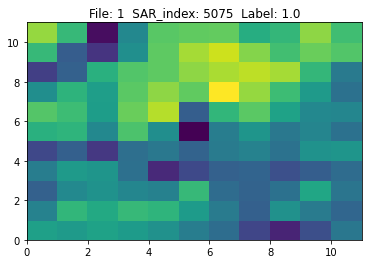

0
1.0


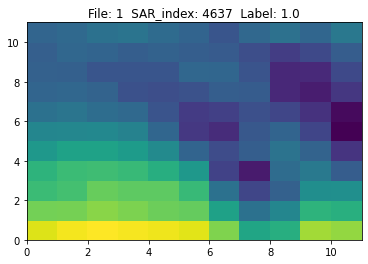

1
0.0


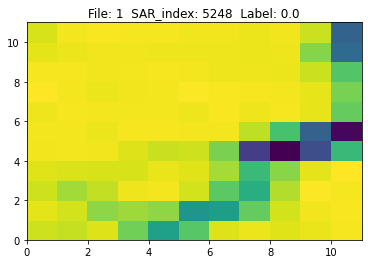

0
1.0


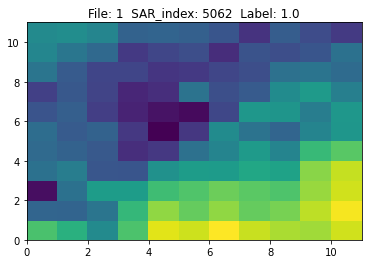

0
1.0


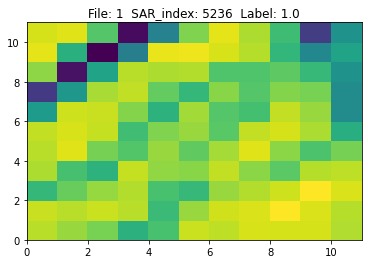

1
0.0


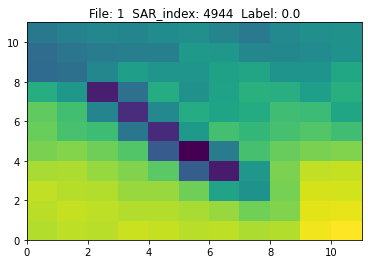

0
1.0


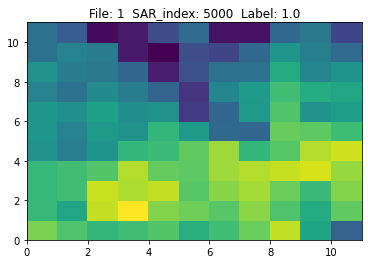

0
1.0


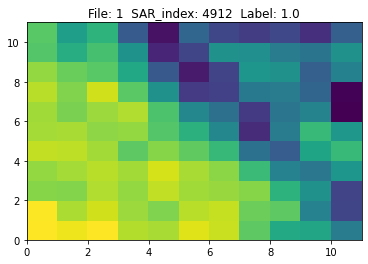

0
1.0


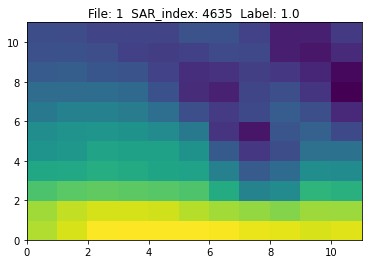

1
0.0


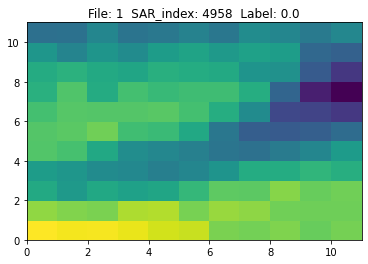

1
0.0


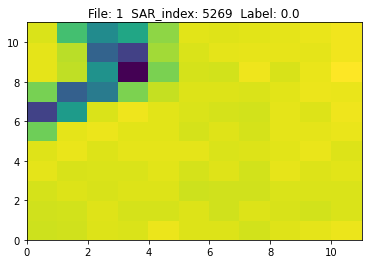

1
0.0


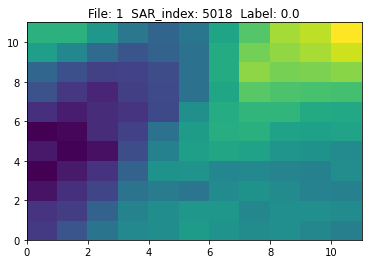

0
1.0


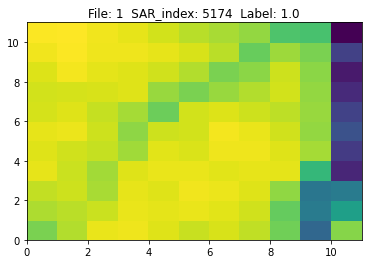

0
1.0


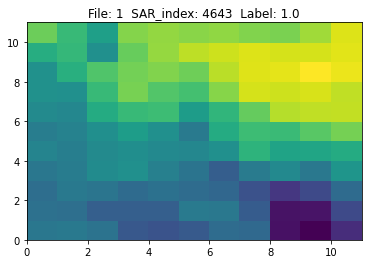

0
1.0


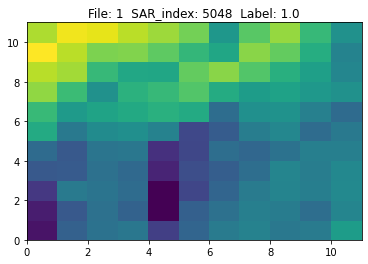

0
1.0


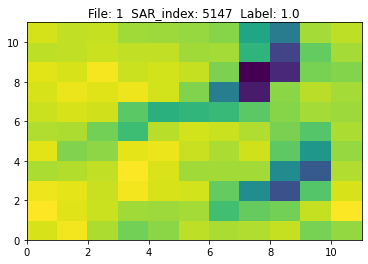

In [77]:
# Don't match
print(validation_predictions[3])
print(validation_labels[3])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[3], validation_indices[3], validation_labels[3]))
plt.pcolor(validation_images[3,:,:,0])
plt.show()

print(validation_predictions[5])
print(validation_labels[5])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[5], validation_indices[5], validation_labels[5]))
plt.pcolor(validation_images[5,:,:,0])
plt.show()

print(validation_predictions[33])
print(validation_labels[33])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[33], validation_indices[33], validation_labels[33]))
plt.pcolor(validation_images[33,:,:,0])
plt.show()

print(validation_predictions[44])
print(validation_labels[44])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[44], validation_indices[44], validation_labels[44]))
plt.pcolor(validation_images[44,:,:,0])
plt.show()

print(validation_predictions[64])
print(validation_labels[64])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[64], validation_indices[64], validation_labels[64]))
plt.pcolor(validation_images[64,:,:,0])
plt.show()

print(validation_predictions[67])
print(validation_labels[67])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[67], validation_indices[67], validation_labels[67]))
plt.pcolor(validation_images[67,:,:,0])
plt.show()


print(validation_predictions[72])
print(validation_labels[72])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[72], validation_indices[72], validation_labels[72]))
plt.pcolor(validation_images[72,:,:,0])
plt.show()

print(validation_predictions[75])
print(validation_labels[75])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[75], validation_indices[75], validation_labels[75]))
plt.pcolor(validation_images[75,:,:,0])
plt.show()

print(validation_predictions[95])
print(validation_labels[95])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[95], validation_indices[95], validation_labels[95]))
plt.pcolor(validation_images[95,:,:,0])
plt.show()

print(validation_predictions[115])
print(validation_labels[115])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[115], validation_indices[115], validation_labels[115]))
plt.pcolor(validation_images[115,:,:,0])
plt.show()

print(validation_predictions[118])
print(validation_labels[118])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[118], validation_indices[118], validation_labels[118]))
plt.pcolor(validation_images[118,:,:,0])
plt.show()

print(validation_predictions[126])
print(validation_labels[126])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[126], validation_indices[126], validation_labels[126]))
plt.pcolor(validation_images[126,:,:,0])
plt.show()

print(validation_predictions[127])
print(validation_labels[127])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[127], validation_indices[127], validation_labels[127]))
plt.pcolor(validation_images[127,:,:,0])
plt.show()

print(validation_predictions[128])
print(validation_labels[128])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[128], validation_indices[128], validation_labels[128]))
plt.pcolor(validation_images[128,:,:,0])
plt.show()

print(validation_predictions[135])
print(validation_labels[135])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[135], validation_indices[135], validation_labels[135]))
plt.pcolor(validation_images[135,:,:,0])
plt.show()

print(validation_predictions[138])
print(validation_labels[138])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[138], validation_indices[138], validation_labels[138]))
plt.pcolor(validation_images[138,:,:,0])
plt.show()

print(validation_predictions[141])
print(validation_labels[141])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[141], validation_indices[141], validation_labels[141]))
plt.pcolor(validation_images[141,:,:,0])
plt.show()

print(validation_predictions[185])
print(validation_labels[185])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[185], validation_indices[185], validation_labels[185]))
plt.pcolor(validation_images[185,:,:,0])
plt.show()

print(validation_predictions[195])
print(validation_labels[195])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[195], validation_indices[195], validation_labels[195]))
plt.pcolor(validation_images[195,:,:,0])
plt.show()

print(validation_predictions[208])
print(validation_labels[208])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[208], validation_indices[208], validation_labels[208]))
plt.pcolor(validation_images[208,:,:,0])
plt.show()

print(validation_predictions[210])
print(validation_labels[210])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[210], validation_indices[210], validation_labels[210]))
plt.pcolor(validation_images[210,:,:,0])
plt.show()

print(validation_predictions[233])
print(validation_labels[233])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[233], validation_indices[233], validation_labels[233]))
plt.pcolor(validation_images[233,:,:,0])
plt.show()

print(validation_predictions[252])
print(validation_labels[252])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[252], validation_indices[252], validation_labels[252]))
plt.pcolor(validation_images[252,:,:,0])
plt.show()

print(validation_predictions[255])
print(validation_labels[255])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[255], validation_indices[255], validation_labels[255]))
plt.pcolor(validation_images[255,:,:,0])
plt.show()

print(validation_predictions[256])
print(validation_labels[256])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[256], validation_indices[256], validation_labels[256]))
plt.pcolor(validation_images[256,:,:,0])
plt.show()

print(validation_predictions[265])
print(validation_labels[265])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[265], validation_indices[265], validation_labels[265]))
plt.pcolor(validation_images[265,:,:,0])
plt.show()

print(validation_predictions[267])
print(validation_labels[267])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[267], validation_indices[267], validation_labels[267]))
plt.pcolor(validation_images[267,:,:,0])
plt.show()

print(validation_predictions[274])
print(validation_labels[274])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[274], validation_indices[274], validation_labels[274]))
plt.pcolor(validation_images[274,:,:,0])
plt.show()

print(validation_predictions[279])
print(validation_labels[279])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[279], validation_indices[279], validation_labels[279]))
plt.pcolor(validation_images[279,:,:,0])
plt.show()

print(validation_predictions[291])
print(validation_labels[291])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[291], validation_indices[291], validation_labels[291]))
plt.pcolor(validation_images[291,:,:,0])
plt.show()

print(validation_predictions[302])
print(validation_labels[302])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[302], validation_indices[302], validation_labels[302]))
plt.pcolor(validation_images[302,:,:,0])
plt.show()

print(validation_predictions[317])
print(validation_labels[317])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[317], validation_indices[317], validation_labels[317]))
plt.pcolor(validation_images[317,:,:,0])
plt.show()

print(validation_predictions[319])
print(validation_labels[319])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[319], validation_indices[319], validation_labels[319]))
plt.pcolor(validation_images[319,:,:,0])
plt.show()

print(validation_predictions[328])
print(validation_labels[328])
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[328], validation_indices[328], validation_labels[328]))
plt.pcolor(validation_images[328,:,:,0])
plt.show()



**Looking at the images in context of larger 71x71 images**

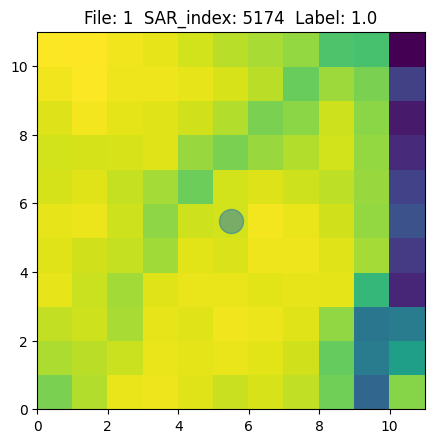

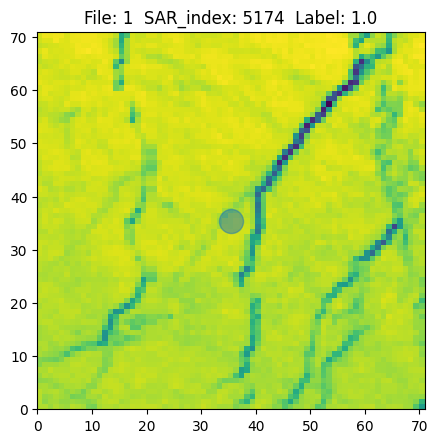

In [184]:
SAR_index=5174 # looking at image with this SAR_index in validation_images
find_element = [i for i in range(len( validation_indices)) if validation_indices[i] == SAR_index] # find the element which has the specified SAR index in validation_labels 
n_n=find_element # element in validation_images which has image associated with SAR_index
n=int(n_n[0])

n0=validation_indices[n]
nfile=validation_files[n]

match_indices_list=CNN_training[OLCI_file_list[nfile-1]]['match_indices_list']
flag=CNN_training[OLCI_file_list[nfile-1]]['flag']
OLCI_data=CNN_training[OLCI_file_list[nfile-1]]['OLCI_data']
SAR_lon=CNN_training[OLCI_file_list[nfile-1]]['SAR_lon']
OLCI_closest=match_indices_list[n0][nfile-1] # index of closest OLCI point to SAR point
i0=index0[nfile-1][OLCI_closest]
i1=index1[nfile-1][OLCI_closest]

image_e=[]
for r in range(1,22): # just looking at first rafiance band
    image_e.append(OLCI_data[r-1][i0-5:i0+6,i1-5:i1+6])
plt.figure(figsize=(5,5),dpi=100)
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[n], validation_indices[n], validation_labels[n]))
plt.pcolor(image_e[0][:,:])
# plt.pcolor(image_e[3][:,:]/image_e[8][:,:])
plt.scatter(5.5,5.5,s=300,alpha=0.5)
plt.show()

image_e_b=[]
for r in range(1,22): # just looking at first rafiance band
    image_e_b.append(OLCI_data[r-1][i0-35:i0+36,i1-35:i1+36])
plt.figure(figsize=(5,5),dpi=100)
plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[n], validation_indices[n], validation_labels[n]))
plt.pcolor(image_e_b[0][:,:])
# plt.pcolor(image_e[3][:,:]/image_e[8][:,:])
plt.scatter(35.5,35.5,s=300,alpha=0.5)
plt.show()


    


**visually label images that do not match**

In [185]:
n=(len(not_equal_elements_val))
visual_labels_val=np.ndarray(n)
visual_labels_val[0]=1 
visual_labels_val[1]=0 
visual_labels_val[2]=0 
visual_labels_val[3]=1 
visual_labels_val[4]=1 
visual_labels_val[5]=1 
visual_labels_val[6]=1 
visual_labels_val[7]=1 
visual_labels_val[8]=1 
visual_labels_val[9]=1 

visual_labels_val[10]=1 
visual_labels_val[11]=1 
visual_labels_val[12]=1  
visual_labels_val[13]=1 
visual_labels_val[14]=0 
visual_labels_val[15]=0 
visual_labels_val[16]=0 
visual_labels_val[17]=0 
visual_labels_val[18]=1 
visual_labels_val[19]=1 

visual_labels_val[20]=0 
visual_labels_val[21]=1 
visual_labels_val[22]=0  
visual_labels_val[23]=1 
visual_labels_val[24]=1 
visual_labels_val[25]=1 
visual_labels_val[26]=1 
visual_labels_val[27]=1 
visual_labels_val[28]=0 
visual_labels_val[29]=1 

visual_labels_val[30]=0
visual_labels_val[31]=1 
visual_labels_val[32]=1 
visual_labels_val[33]=1 

In [186]:
# Can compare accuracy of visual labels wrt SL labels
match=[i for i, j in zip(validation_labels_no_match, visual_labels_val) if i == j]
print('Number of elements in  validation_labels_no_match and visual_labels_val arrays:', len(validation_labels_no_match))
print('Number of matching elements:', len(match))
print('Percentage of visual labels which match with the non-matcing SL labels: ', len(match)/len(validation_labels_no_match) )

Number of elements in  validation_labels_no_match and visual_labels_val arrays: 34
Number of matching elements: 25
Percentage of visual labels which match with the non-matcing SL labels:  0.7352941176470589


In [187]:
# Can compare accuracy of visual labels wrt SL labels
match=[i for i, j in zip(validation_predictions_no_match, visual_labels_val) if i == j]
print('Number of elements in  validation_labels_no_match and visual_labels_val arrays:', len(validation_predictions_no_match))
print('Number of matching elements:', len(match))
print('Percentage of visual labels which match with the non-matcing SL labels: ', len(match)/len(validation_predictions_no_match) )

Number of elements in  validation_labels_no_match and visual_labels_val arrays: 34
Number of matching elements: 9
Percentage of visual labels which match with the non-matcing SL labels:  0.2647058823529412


**Visually look at images that match**

In [135]:
# # Look at images where the labels match
# print(validation_predictions[2])
# print(validation_labels[2])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[2], validation_indices[2], validation_labels[2]))
# plt.pcolor(validation_images[2,:,:,0])
# plt.show()


# print(validation_predictions[10])
# print(validation_labels[10])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[10], validation_indices[10], validation_labels[10]))
# plt.pcolor(validation_images[10,:,:,0])
# plt.show()


# print(validation_predictions[30])
# print(validation_labels[30])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[30], validation_indices[30], validation_labels[30]))
# plt.pcolor(validation_images[30,:,:,0])
# plt.show()

# print(validation_predictions[70])
# print(validation_labels[70])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[70], validation_indices[70], validation_labels[70]))
# plt.pcolor(validation_images[70,:,:,0])
# plt.show()

# print(validation_predictions[10])
# print(validation_labels[10])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[10], validation_indices[10], validation_labels[10]))
# plt.pcolor(validation_images[10,:,:,0])
# plt.show()

# print(validation_predictions[220])
# print(validation_labels[220])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[220], validation_indices[220], validation_labels[220]))
# plt.pcolor(validation_images[220,:,:,0])
# plt.show()

# print(validation_predictions[200])
# print(validation_labels[200])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[200], validation_indices[200], validation_labels[200]))
# plt.pcolor(validation_images[200,:,:,0])
# plt.show()

# print(validation_predictions[300])
# print(validation_labels[300])
# plt.title('File: {}  SAR_index: {}  Label: {}'.format(validation_files[300], validation_indices[300], validation_labels[300]))
# plt.pcolor(validation_images[300,:,:,0])
# plt.show()

## Validating the CNN Using Visually Labelled data --> NOTES (not using currently)--> used some of this above 

**Do this part once CNN has higher accuracy**

In [ ]:
from numpy import loadtxt
test_labels_int=test_labels.astype(int)
print(test_labels_int)
print('')
val_labels_1=test_labels_int[:-200]
print(val_labels_1)
print('')
val_images_1=test_images[:-200]

print(len(val_labels_1))
print(np.shape(val_images_l))

# # must save then re-load data before labelling since everytime the code runs we have new data 
# # save to csv file 
# savetxt('val_labels.csv', val_labels_l, delimiter=',')
# savetxt('val_images.csv', val_images_l, delimiter=',')
# # load array
# val_labels = loadtxt('val_labels.csv', delimiter=',')
# val_images = loadtxt('val_images.csv', delimiter=',')

In [ ]:
# looking at first radiance band of val_images to enable visual labelling
plt.pcolor(val_images[95,:,:,0])
plt.show()

In [ ]:
# Visual Image labelling 
visual_labels=np.zeros(len(val_labels))
visual_labels[0]=
visual_labels[1]=
visual_labels[2]=
visual_labels[3]=
visual_labels[4]=
visual_labels[5]=
visual_labels[6]=
visual_labels[7]=
visual_labels[8]=
visual_labels[9]=

visual_labels[10]=
visual_labels[11]=
visual_labels[12]=
visual_labels[13]=
visual_labels[14]=
visual_labels[15]=
visual_labels[16]=
visual_labels[17]=
visual_labels[18]=
visual_labels[19]=

visual_labels[20]=
visual_labels[21]=
visual_labels[22]=
visual_labels[23]=
visual_labels[24]=
visual_labels[25]=
visual_labels[26]=
visual_labels[27]=
visual_labels[28]=
visual_labels[29]=

visual_labels[30]=
visual_labels[31]=
visual_labels[32]=
visual_labels[33]=
visual_labels[34]=
visual_labels[35]=
visual_labels[36]=
visual_labels[37]=
visual_labels[38]=
visual_labels[39]=

visual_labels[40]=
visual_labels[41]=
visual_labels[42]=
visual_labels[43]=
visual_labels[44]=
visual_labels[45]=
visual_labels[46]=
visual_labels[47]=
visual_labels[48]=
visual_labels[49]=

visual_labels[50]=
visual_labels[51]=
visual_labels[52]=
visual_labels[53]=
visual_labels[54]=
visual_labels[55]=
visual_labels[56]=
visual_labels[57]=
visual_labels[58]=
visual_labels[59]=


In [ ]:
# # Can compare accuracy of visual labels wrt SL labels
# match_1=[i for i, j in zip(val_labels, visual_labels) if i == j]
# print('Number of elements in  val_labels and visual_labels arrays', len(val_labels))
# print('Number of matching elements', len(match_1))
# print('Acuracy of CNN for val images', len(match_1)/len(val_labels) )

# # Can compare accuracy of visual labels wrt SL labels
# match_1=[i for i, j in zip(val_labels, visual_labels) if i == j]
# print('Number of elements in  val_labels and visual_labels arrays', len(val_labels))
# print('Number of matching elements', len(match_1))
# print('Acuracy of CNN for val images', len(match_1)/len(prediction) )